François GOUJON

## Laboratoire 1 - Analyse et préparation des données et extraction de primitives
### GTI771 - Apprentissage machine avancé
#### Département du génie logiciel et des technologies de l’information

#### Version 1.0 janvier 2020
#### <font color=blue> Version 2.0 janvier 2020 </font>
#### <font color=magenta> Version 3.0 février 2020 </font>

##### Prof. Alessandro L. Koerich

## Introduction

Ce premier laboratoire porte sur la définition et l’extraction de primitives sur des visages. Le problème de classification qui vous est présenté est le problème [Facial Expression Recognition (FER)](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data), dont le but est de classer des visages dans sept catégories. En vous basant sur les concepts vus en classe, vous devez définir des primitives que vous jugez pertinentes à extraire sur ces types d’images et effectuer l’extraction de celles-ci sur l’ensemble de données fournies avec cet énoncé.

Veuillez noter que les images qui vous sont fournies ne sont pas nécessairement très faciles à travailler. Plusieurs images comportent du bruit, des artéfacts ou des éléments non pertinents. Le défi de ce laboratoire repose sur cette difficulté qui est chose courante dans des problèmes d’apprentissage machine moderne.

Voici, en exemple, des images de visages se retrouvant dans l’ensemble de données:

![Exemples de FER](https://miro.medium.com/max/2420/1*nXqJ4lMiBRp4Ilm3bpRxuA.png)


L’évaluation de ce laboratoire sera basée sur la qualité des primitives proposées, les réponses aux questions dans cette notebook ainsi que l'organisation de votre code source <font color=blue> (SVP, n'oubliez pas des commentaires dans le code!)</font>. Le pouvoir discriminant, c’est-à-dire la capacité des primitives à bien séparer les exemples des classes dans l’espace des primitives, sera également évalué.

## Partie 1: Imports

#### (1a) Import de bibliotèques

##### À faire:
1. Ajouter toutes les bibliothèques que vous avez utilisées pour compléter ce notebook dans une cellule avec une petite description.

In [1]:
try :
    from google.colab import drive
    drive.mount('/content/drive')
except :
    pass

In [2]:
import numpy as np  # package for scientific computing with Python.
import matplotlib.pyplot as plt # 2D plotting library
import matplotlib.ticker as ticker
import os
import random

import pandas as pd #Bibliothèque de tableaux
import statistics #Bibliothèque statistiques
from scipy import stats #Bibliothèque statistiques
import cv2 as cv #Bibliothèque de visualisation

#Bibliothèque de traitement des images pour l'extraction de primitive
from skimage.filters import gabor
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage.feature import hog
from skimage.color import label2rgb

#Bibliothèque de traitement des données (Normalisation, Reduction de dimension, Création de modèle)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

## Partie 2: Analyse exploratoire des données

On va commencer en regardant les données.

Pour ce lab, nous allons utiliser le dataset FER.

Le dataset est disponible dans https://www.kaggle.com/ahmedmoorsy/facial-expression, et il continent presque 35,000 visages.

### (2a) Charger le fichier de données

In [3]:
# load data
try :
    ferData = np.loadtxt( '/content/drive/MyDrive/resources/fer2013.csv', delimiter=',', dtype=np.str )
except :
    ferData = np.loadtxt( 'fer2013.csv', delimiter=',', dtype=np.str )
 
# Training set
Xtrain = np.ones( (28709,2304), np.uint8 )

for i in range( 1, 28710 ):
    Xtrain[i-1] = ferData[i,1].split(" ")

ytrain = ferData[1:28710,0].astype( np.int )

# Validation set
Xval = np.ones( (3589,2304), float )

for i in range( 28710, 32299 ):
    Xval[i-28710] = ferData[i,1].split(" ")

yval = ferData[28710:32299,0].astype( np.int )

# Test set
Xtest = np.ones( (3589,2304), float )

for i in range( 32299, 35888 ):
    Xtest[i-32299] = ferData[i,1].split(" ")

ytest = ferData[32299:,0].astype( np.int )

print(Xtrain.shape, Xval.shape, Xtest.shape)

(28709, 2304) (3589, 2304) (3589, 2304)


In [4]:
# reshape to be [samples][channels][width][height]
Xtrain = Xtrain.reshape( Xtrain.shape[0], 1, 48, 48 ).astype('uint8')
Xtest  = Xtest.reshape( Xtest.shape[0], 1, 48, 48 ).astype('uint8')
Xval   = Xval.reshape( Xval.shape[0], 1, 48, 48 ).astype('uint8')

print( Xtrain.shape, Xval.shape, Xtest.shape )

(28709, 1, 48, 48) (3589, 1, 48, 48) (3589, 1, 48, 48)


In [5]:
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

### <font color=blue> (2b) Visualisation des visages </font>

Pensez-vous qui c'est necessaire un pre-traitement des images? Si oui, 
[Pre-processing](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing)

In [6]:
WIDTH = 48
HEIGHT = 48

# Fonction permettant d'afficher les images en grille avec l'émotion correspondante
def plot_image_grid(X, y, num_rows=4, num_cols=4, nb_images_to_show=16):    
    # Number of images to plot (from the beginning)
    num_images = num_rows*num_cols    
    
    # Width and height in inches for images in the grid
    plt.figure(figsize=(3*num_rows, 3*num_rows))
    
    # Iterate over images
    for i in range(nb_images_to_show):
        plt.subplot(num_rows, num_cols, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(X[i].reshape(HEIGHT, WIDTH), cmap='gray')  # Plot image
        plt.xlabel(f"{labels[y[i]]}")  # Plot label
    plt.show()

In [7]:
# Suppresion de la dimension représentant le channel pour simplifier l'utilisation du set

Xtrain_reshaped = Xtrain.reshape((Xtrain.shape[0], 48, 48))
print(Xtrain_reshaped.shape)
Xval_reshaped = Xval.reshape((Xval.shape[0], 48, 48))
print(Xval_reshaped.shape)
Xtest_reshaped = Xtest.reshape((Xtest.shape[0], 48, 48))
print(Xtest_reshaped.shape)

(28709, 48, 48)
(3589, 48, 48)
(3589, 48, 48)


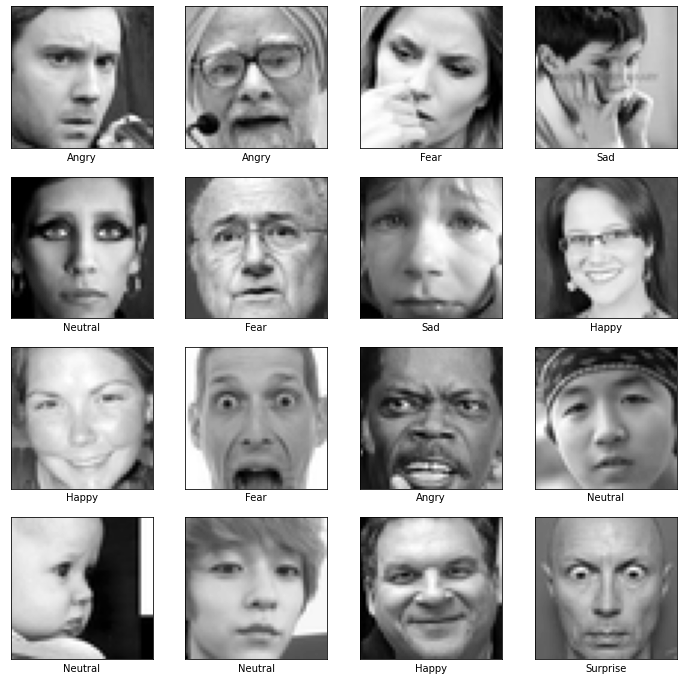

In [8]:
# Affichage des 16 premières images
plot_image_grid(Xtrain_reshaped, ytrain)

### (2b) Statistiques des données

##### À faire:
1. Calculer quelques statistiques (moyenne, écart-type, etc.) que vous jugez importantes sur les données (entrées et sorties)
2. Faire une analyse des résultats et présenter vos conclusions sur ces statistiques.

### Partie 2b: Code:

In [9]:
# fonction pour connaître la tête moyenne de chaque emotion
def plot_moy_labels(X, y, labels=labels):
    moy_images = []
    indexes = []
    for id_label in range(len(labels)):
        arr_images = X[y==id_label]
        print(f'{labels[id_label]}: {len(arr_images)}')
        moy_images.append(np.mean(arr_images, axis=0))
        indexes.append(id_label)

    return np.vstack(moy_images)

#fonction ayant pour but de mesurer la ou la variance est la plus forte sur les images
def plot_var(X, w=WIDTH, h=HEIGHT, ecart_t=False): 
    if ecart_t:
        resultat = np.std(X, axis=0)
    else:
        resultat = np.var(X, axis=0)
    plt.imshow(resultat.reshape((w, h)), cmap='gray')
    plt.show()
    #return resultat
    
# fonction pour connaître la tête moyenne de toutes les images
def moyenne_all(arr_images, w=WIDTH, h=HEIGHT):
    moyenne = np.mean(arr_images, axis=0)
    plt.imshow(moyenne.reshape(w, h),cmap='gray')
    plt.show()
    
# fonction d'équilibrage des données dans chaque dataset (voir histogramme plus bas)

def equilibre_datasets(data,label,n):# n : nombre d'item par classe
    nitems=label.shape[0]
    new_dataset=[]
    new_labels=[]
    #new_dataset=np.zeros(  (nitems, 48, 48) )
    #new_labels=np.zeros(  (nitems) )
    occurences = np.zeros((7))
    
    for i in range(nitems) :
        if occurences[label[i]] < n :
            new_dataset.append(data[i])
            new_labels.append(label[i])
            occurences[label[i]]+=1
    return np.array(new_dataset),np.array(new_labels)

In [10]:
# Création des visages moyens
moyenne = plot_moy_labels(Xtrain, ytrain)
moyenne_reshaped = moyenne.reshape((moyenne.shape[0], 1, moyenne.shape[1], -1))

Angry: 3995
Disgust: 436
Fear: 4097
Happy: 7215
Sad: 4830
Surprise: 3171
Neutral: 4965


In [11]:
# Normalisation des données :
# Reshaping pour la normalisation
XtrainScal = Xtrain.reshape( Xtrain.shape[0], 2304 ).astype('uint8')
XvalScal = Xval.reshape( Xval.shape[0], 2304 ).astype('uint8')
print(XtrainScal)
XtrainScal = StandardScaler().fit_transform(XtrainScal) # normalisation
XvalScal = StandardScaler().fit_transform(XvalScal) # normalisation
print(XtrainScal)
XtrainScal = XtrainScal.reshape( XtrainScal.shape[0], 1, 48, 48 ).astype('uint8')
XvalScal = XvalScal.reshape( XvalScal.shape[0], 1, 48, 48 ).astype('uint8')
print(XtrainScal.shape)
print(XvalScal.shape)

[[ 70  80  82 ... 106 109  82]
 [151 150 147 ... 193 183 184]
 [231 212 156 ...  88 110 152]
 ...
 [ 74  81  87 ... 188 187 187]
 [222 227 203 ... 136 136 134]
 [195 199 205 ...   6  15  38]]
[[-0.60988232 -0.45922179 -0.40324932 ... -0.08629621 -0.05737476
  -0.41127695]
 [ 0.37236201  0.40461631  0.41101767 ...  1.0387427   0.89140538
   0.88666892]
 [ 1.34247986  1.16973007  0.52376233 ... -0.31906288 -0.04455341
   0.47947022]
 ...
 [-0.56137642 -0.44688125 -0.3406134  ...  0.97408529  0.94269079
   0.9248438 ]
 [ 1.2333416   1.35483823  1.11254    ...  0.30164824  0.28880177
   0.25042095]
 [ 0.90592683  1.00930299  1.13759436 ... -1.37944439 -1.26258197
  -0.97117517]]
(28709, 1, 48, 48)
(3589, 1, 48, 48)


### Partie 2b: Résultats et résponses:

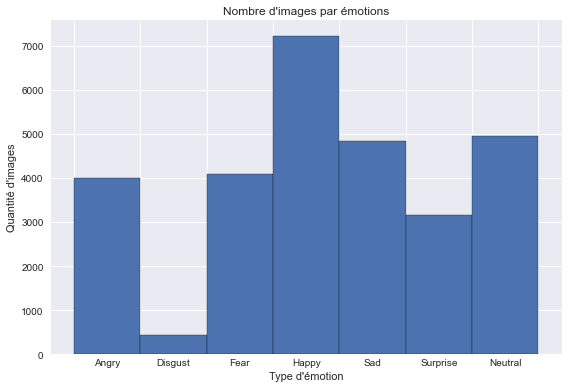

In [12]:
# Plot de l'histogramme pour Xtrain
plt.style.use('seaborn')

fig, ax = plt.subplots()

ax.hist(ytrain, bins=[0, 1, 2, 3, 4, 5, 6, 7], edgecolor='black')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(labels))

plt.title('Nombre d\'images par émotions')
plt.xlabel('Type d\'émotion')
plt.ylabel('Quantité d\'images')

plt.tight_layout()
plt.show()

**On remarque ici un problème : nos classes ne sont pas équilibrées. En effet, il n'y a que 436 images "Disgust" pour 7215 "Happy" dans le set de train. Afin de les équilibrer nous pourrions réduire le nombre d'images, cependant la classe 1 (DISGUST) ne comporte que très peu d'individus, ce qui ne permettrait pas d'entraîner le modèle correctement.**

**Il faut donc prendre en considération ce problème pour la suite et chercher une solution pour ne pas sur-entraîner le modèle sur certaine classes.**

**Nous essaierons donc de mettre en place une alternative pour équilibrer les dataset (fonction equilibre_datasets)**

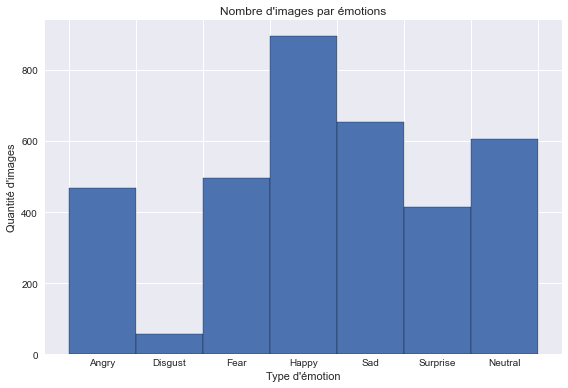

In [13]:
# Plot histogramme pour Xval
plt.style.use('seaborn')

fig, ax = plt.subplots()

ax.hist(yval, bins=[0, 1, 2, 3, 4, 5, 6, 7], edgecolor='black')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(labels))

plt.title('Nombre d\'images par émotions')
plt.xlabel('Type d\'émotion')
plt.ylabel('Quantité d\'images')

plt.tight_layout()
plt.show()

**Le problème de répartition des images reste présent dans le set de validation**

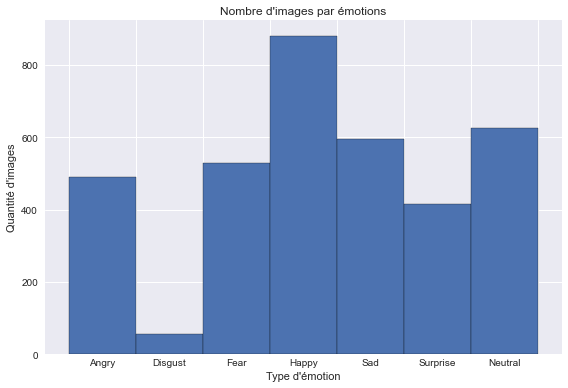

In [14]:
# Plot histogramme Xtest
plt.style.use('seaborn')

fig, ax = plt.subplots()

ax.hist(ytest, bins=[0, 1, 2, 3, 4, 5, 6, 7], edgecolor='black')
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5]))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(labels))

plt.title('Nombre d\'images par émotions')
plt.xlabel('Type d\'émotion')
plt.ylabel('Quantité d\'images')

plt.tight_layout()
plt.show()

**Le problème de répartition des images reste présent dans le set de test**

### On trace ici des images où l'on moyenne la valeur de chaque pixel pour un label donné

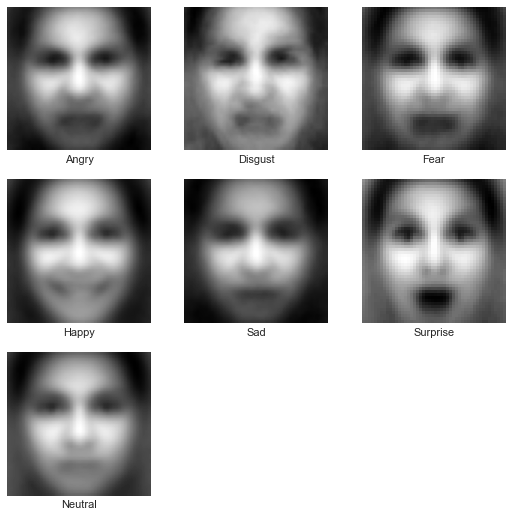

In [15]:
plot_image_grid(moyenne, range(7), 3, 3, 7)

**On remarque des différences entre les divers labels, ce qui pourrait nous permettre de désigner certaines primitives. En effet, on remarque que la moyenne des images d'une certaine émotion est très représentative de l'émotion.**

### Image de l'écart-type sur l'ensemble des visages

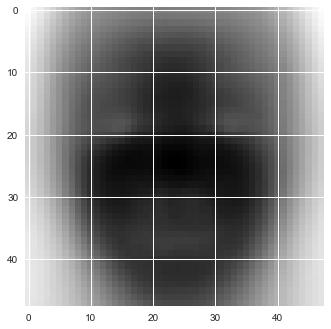

In [16]:
plot_var(Xtrain,ecart_t=True) # écart-type ensemble des visages

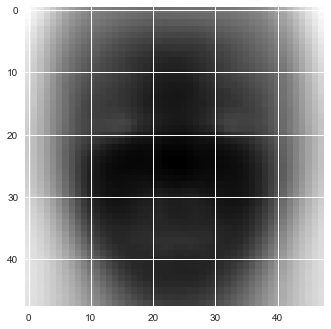

In [17]:
plot_var(Xtrain ,ecart_t=False) # Variance ensemble des visages

On observe que le fond a assez peu de variance, en effet, toutes ces personnes sont prises sur un fond uni et elles sont centrées sur l'image.
Sur le visage, la bouche ainsi que les yeux présentent une faible ceci peut sembler étonnant.

A l'inverse, les zones avec le plus de fluctuations sont les joues, le nez et le milieu du front. Cela paraît cohérent : la rondeur des joues varies beaucoup avec l'expression du visage ; le front est une partie qui se ride lorsque nous avons le visage fermé.

### Variance et écart-type entre les labels

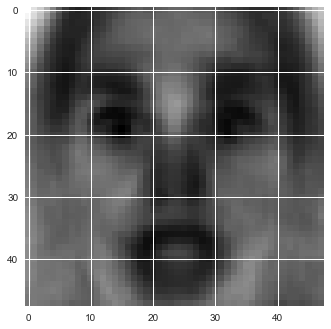

In [18]:
variance = plot_var(moyenne_reshaped)
# Variance entre les 7 images représentant les moyennes pour chaque émotion

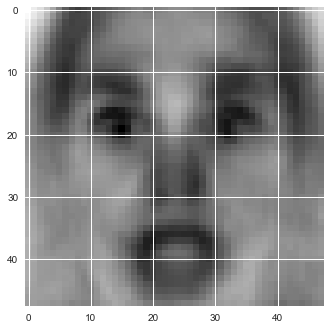

In [19]:
ecart_type = plot_var(moyenne_reshaped, ecart_t=True)
# Écart-type entre les 7 images représentant les moyennes pour chaque émotion

Cette image montre la variance entre les diverses images obtenues précedemment ( images présentant la moyenne de chaque pixel pour chaque label).  

On remarque ainsi les zones variant le plus d'un comportement moyen à un autre. Ainsi la bouche, le nez, les sourcils et les yeux semblent être de bonnes primitives pour déterminer nos labels. Ceci peut sembler assez logique.

Les cheveux semblent aussi beaucoup varier, nous pouvons cependant remettre en question cette primitive. En effet, que je sois énervé ou heureux, il reste peu probable que je choississe de me coiffer différement. On pourrait plutôt interpréter cela comme la diversité de chevelures entre les photos.

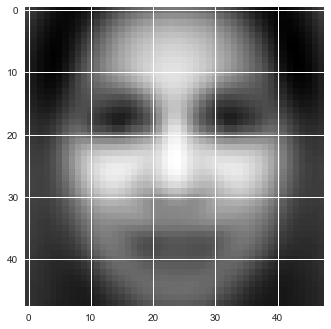

In [20]:
moyenne_all(Xtrain)  # Moyenne de l'ensemble des visages du set Xtrain

Le plot de cette image permet de vérifier que malgré le moyennage effectué, nous retrouvons toujours les caractéristiques d'un visage. En effet, effectuer la moyenne pixel par pixel pour des milliers d'images prises avec des angles, distances, exposition, etc différentes aurait pu donner un résultat qui ne ressemble en rien à un visage. Cette image nous permet donc de présumer que travailler avec des moyennes produites de cette façon n'est pas une mauvaise pratique.

### Nous visualisons les données normalisées pour étudier les différences avec précédement

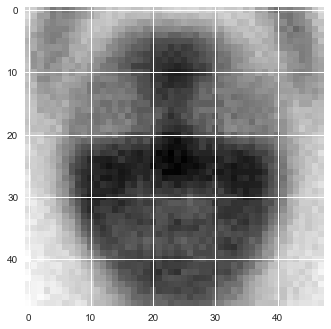

In [21]:
plot_var(XtrainScal,ecart_t=True) # écart-type ensemble des visages normalisés

Une fois les données normalisés il n'est plus évident de reconnaître un visage. Cependant, nous pouvons toujours distinguer la bouche, les yeux et le contour du visage.
Tout comme nous l'avions déjà remarqué plus tôt avec l'écart type sur les données non normalisées, les zones de plus fortes variances sont les joues, le nez et le front.

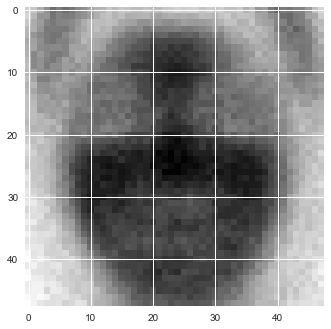

In [22]:
moyenne_all(XtrainScal) # moyenne de toutes les têtes normalisés

La moyenne de tous les visages après la normlisation est identique à l'écart-type ce qui est cohérent car les données sont normalisées.

### On trace ici des images où l'on moyenne la valeur de chaque pixel pour un label donné pour les données normalisées

In [23]:
resScal=plot_moy_labels(XtrainScal,ytrain) # Image normalisée moyenne par label

Angry: 3995
Disgust: 436
Fear: 4097
Happy: 7215
Sad: 4830
Surprise: 3171
Neutral: 4965


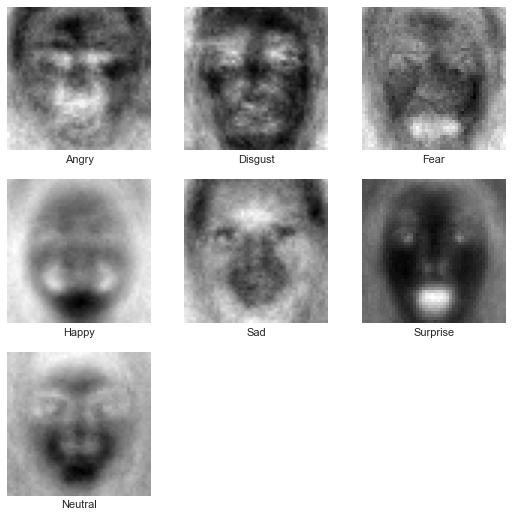

In [24]:
plot_image_grid(resScal, range(7), 3, 3, 7)

On remarque toujours des différences entre les différentes moyennes mais cela devient moins clair qu'avant la normalisation.

### (2c) Créer et évaluer un modèle de base (baseline)

Un modèle très simple, mais naturel est une ou nous calculons un modèle moyen (template) pour chaque classe (sur les données d'apprentissage) et nous utilisons ces modèles (templates) pour faire des prédictions sur des nouvelles données.

##### À faire:
1. Créer un template pour chaque classe
2. Faire un plot de chaque template <font color=blue> (visage moyen) </font>
3. Classifier tous les exemples (ensembles d'apprentissage, validation et test) et reporter les résultats:<br>
 3a. taux de classification correct sur les trois (3) ensembles de données<br>
 3b. matrice de confusion pour les résultas sur l'ensemble de test
4. Faire une analyse des résultats et présenter vos conclusions sur ce modèle

### Partie 2c: Code:

In [14]:
hist, _ = np.histogram(ytrain, density=False, bins=7, range=(0, 7))
# Fonction de création des templates
def creation_list_templates(Xtrain,ytrain):
    list_new_img=[]
    for id_label in range( 7):
        new_image=np.zeros(  (1, 48, 48) )
        count=hist[id_label]

        for i in range(len(Xtrain)) :
            if ytrain[i]==id_label :
                new_image+=(Xtrain[i])
        new_image = new_image/count
        list_new_img.append(new_image)
        
    return np.array(list_new_img)


# Fonction d'affichage des templates
def plot_templates(list_templates):
    plt.figure(figsize=(9, 9))
    
    for id_label in range(len(labels)):
        plt.subplot(3, 3, id_label+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(list_templates[id_label][0].reshape(WIDTH, HEIGHT), cmap='gray')  # Plot image
        plt.xlabel(f"{labels[id_label]}")
    
    plt.show()

# Fonction pour évaluer la qualité des prédictions
def comparaison_prediction(predictions, y):
    nb_correctes = 0
    nb_fausses = 0
    nb_images = len(predictions)
    nb_corr_emo = np.zeros(7, dtype=int)
    nb_fau_emo = np.zeros(7, dtype=int)
    matrice = np.zeros( (7,7), dtype=int) # reel en ligne, prediction en colonne
    for i in range(nb_images):
        matrice[y[i], int(predictions[i])] += 1
        if predictions[i]==y[i]:
            nb_correctes += 1
            nb_corr_emo[y[i]] += 1
        else :
            nb_fausses += 1
            nb_fau_emo[y[i]] += 1
    print("Taux de classification correctes : "+ str((nb_correctes/nb_images)*100) + "%")
    
    print(" Matrice de confusion" )
    print(matrice)
            
    # return nb_corr_emo, nb_fau_emo, nb_correctes/nb_images, nb_fausses/nb_images, matrice
    
# Fonction de création du modèle avec templates avec un mecanisme de plus proche voisin SK learn 1-NN
def modele_avec_templates_1Neigh(templates):
    templatesreshape = templates.reshape(templates.shape[0], 2304).astype('uint8')
    neigh = KNeighborsClassifier(n_neighbors=1)
    target = [0,1,2,3,4,5,6]
    neigh.fit(templatesreshape, target)
        
    return neigh


# Fonction de prédiction avec templates et un mecanisme de plus proche voisin avec distance norme L2 : =(a-b)**2 , fait main
def prediction_avec_templates_distanceCarree(templates, X):
    predictions=[]
    for image in range(len(X)) :
        distancepixelemotion = np.zeros (len(templates))
        for i in range(48):
            for j in range(48):
                pixelimage = X[image,0,i,j]
                for t in range(len(templates)):
                    distancepixelemotion[t] += (pixelimage - templates[t,0,i,j])**2
        
        predictionemotion = distancepixelemotion.argmin()
        predictions.append(predictionemotion)
        print("Image n°"+str(image)+" : émotion n°"+str(predictionemotion))
    
    
    return np.array(predictions)

# Affichage Matrice confusion
# reel en ligne, prediction en colonne
def print_matrice_confusion(predictions,y):
    nb_images = len(predictions)
    matrice = np.zeros( (7,7), dtype=int)
    for i in range(nb_images):
        matrice[y[i], int(predictions[i])] += 1
    print(" Matrice de confusion" )
    print(matrice)
    
# Fonction pour évaluer la qualité des prédictions sur la totalité du dateset
# ainsi que la matrice de confusion pour Xtest
def print_result(model,Xtrain,ytrain,Xval,yval,Xtest,ytest,printed=False):
    L=[[Xtrain,ytrain,"train"],[Xval,yval,"val"],[Xtest,ytest,"test"]]
    for datasets in L :
        data,label=datasets[0],datasets[1]
        if len(data.shape) == 2 : 
            dataReshape = data.astype('uint8')
        if len(data.shape) == 3 :
            dataReshape = data.reshape(data.shape[0], data.shape[1]*data.shape[2]).astype('uint8')
        if len(data.shape) == 4 : 
            dataReshape = data.reshape(data.shape[0], data.shape[1]*data.shape[2]*data.shape[3]).astype('uint8')    
    
        preds=model.predict(dataReshape)
        
        
        nb_correctes = 0
        nb_fausses = 0
        nb_images = len(preds)
        for i in range(nb_images):
            if i%250==0 and printed:
                print(i,"/",nb_images)
            if preds[i]==label[i]:
                #print()
                nb_correctes += 1
            else :
                nb_fausses += 1
        
        
        print(datasets[2] + " - Taux de classification correctes : "+ str(  (nb_correctes/nb_images)*100 ) +"%")
    print_matrice_confusion(preds,label)

### Partie 2c: Résultats et résponses:

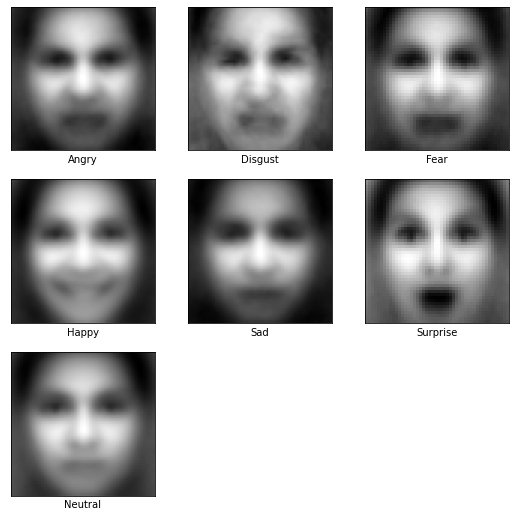

In [15]:
# Étape 1 : création d'un template pour chaque classe

templates = creation_list_templates(Xtrain,ytrain)

# Étape 2 : plot de chaque template

plot_templates(templates)

In [16]:
# Prediction sur Xval avec méthode 1 : 1-NN SK learn 
modele1NNTemplates = modele_avec_templates_1Neigh(templates)

In [27]:
# comparaisons avec yval : matrice de confusion
comparaison_prediction(predictionsKneighVal ,yval)

Taux de classification correctes : 22.095291167456114%
 Matrice de confusion
[[ 20  33  35  37 143 145  54]
 [  2   5   6   3  15  18   7]
 [ 19  36  42  22 112 206  59]
 [ 40  60  53 104 232 259 147]
 [ 35  33  58  35 265 144  83]
 [ 16  17  24  23  51 233  51]
 [ 17  44  32  42 181 167 124]]


In [18]:
# Étape 3 : Classification de tous les exemples et matrice de confusion sur Xtest
print_result(modele1NNTemplates, Xtrain, ytrain, Xval, yval, Xtest, ytest)

train - Taux de classification correctes : 21.195443937441222%
val - Taux de classification correctes : 22.095291167456114%
test - Taux de classification correctes : 21.760936193925883%
 Matrice de confusion
[[ 38  37  37  25 140 142  72]
 [  4   5   1   8  17  17   3]
 [ 23  35  46  29 115 216  64]
 [ 40  55  51  92 239 252 150]
 [ 42  31  51  27 246 127  70]
 [  9  21  25  26  53 237  45]
 [ 21  43  41  41 197 166 117]]


La matrice de confusion se lit de la façon suivante :
Chaque ligne représente les classes réelles et chaque colonne représente les classes prédites.
Ainsi, la diagonale de la matrice représente les bonnes prédictions. On remarque qu'une grande partie des images sont prédites comme étant de la classe 4 et 5 (SAD et SURPRISE). Cela ne semble pas lié à la répartition des images car ces 2 classes ne présentes pas particulièrement plus d'individus dans le set Xtest.

### Nous choisissons donc ce modèle comme notre baseline

In [ ]:
# Étape 4 : analyse des résultats et conclusion sur le modèle.

Nous trouvons des résultats stable sur les 3 set : autour de 22%. Le modèle prédit donc presque 2 fois mieux qu'un modèle aléatoire : 1/7 = 0,143. Cela n'est pas exceptionnel, cepandant, pour un modèle aussi simple en comparaison à la diffculté du problème de prédiction d'émotion, les résultats paraissent sastisfaisant. De plus, l'execution est quasi instantanée.
Nous remarquons tout de même des biais avec certaines classes beaucoup plus prédites que d'autres. Ce déséquilibrage est surprenant.

#### Afin de vérifier le comportement de la fonction, nous avons également essayé d'utiliser une méthode 1-NN sans utiliser sckit-learn

In [28]:
# Prediction sur Xval avec méthode 2 : 1-NN fais main (temps d'exec long)
# Nous ne prédisons que pour Xval, le temps d'éxuction étant long
predictionsDistanceVal = prediction_avec_templates_distanceCarree(templates, Xval)

Image n°0 : émotion n°5
Image n°1 : émotion n°5
Image n°2 : émotion n°0
Image n°3 : émotion n°5
Image n°4 : émotion n°3
Image n°5 : émotion n°3
Image n°6 : émotion n°0
Image n°7 : émotion n°0
Image n°8 : émotion n°2
Image n°9 : émotion n°5
Image n°10 : émotion n°5
Image n°11 : émotion n°5
Image n°12 : émotion n°4
Image n°13 : émotion n°5
Image n°14 : émotion n°6
Image n°15 : émotion n°5
Image n°16 : émotion n°2
Image n°17 : émotion n°5
Image n°18 : émotion n°5
Image n°19 : émotion n°6
Image n°20 : émotion n°5
Image n°21 : émotion n°5
Image n°22 : émotion n°4
Image n°23 : émotion n°5
Image n°24 : émotion n°0
Image n°25 : émotion n°4
Image n°26 : émotion n°4
Image n°27 : émotion n°4
Image n°28 : émotion n°5
Image n°29 : émotion n°6
Image n°30 : émotion n°2
Image n°31 : émotion n°4
Image n°32 : émotion n°4
Image n°33 : émotion n°4
Image n°34 : émotion n°4
Image n°35 : émotion n°4
Image n°36 : émotion n°3
Image n°37 : émotion n°5
Image n°38 : émotion n°2
Image n°39 : émotion n°3
Image n°40

In [29]:
# comparaisons avec yval : matrice de confusion sur Xval (ne pas comparer avec la précédente sur Xtest)
comparaison_prediction(predictionsDistanceVal ,yval)

Taux de classification correctes : 22.095291167456114%
 Matrice de confusion
[[ 20  33  35  33 145 143  58]
 [  2   5   5   3  16  18   7]
 [ 19  38  43  21 113 202  60]
 [ 37  60  52 104 236 256 150]
 [ 39  32  59  33 268 138  84]
 [ 14  17  26  23  53 231  51]
 [ 17  45  32  42 184 165 122]]


Nous retrouvons le même taux de classification que prédement pour le set val. La fonction a bien le même comportement mais le temps de calcul est bien plus long.

## Partie 3: Extraction de primitives

Vous devez faire une recherche bibliographique pour trouver quelles sont les primitives qui sont plus souvent utilisées pour la reconnaissance des expressions faciales. Voici quelques sources et mot-clés pour guider votre recherche:

- https://doi.org/j.imavis.2008.08.005
- http://www.inf.ufpr.br/lesoliveira/download/ESWA2013.pdf
- https://doi.org/10.1016/j.patrec.2015.06.007 
- https://doi.org/10.1109/FG.2011.5771374


##### mots-clés: facial expression recognition, facial emotion recognition.


### Bibliotèques Python pour l'extraction de primitives

* [Scikit-image](https://scikit-image.org/docs/dev/)
* [OpenCV](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_tutorials.html)
* [Scikit-learn](https://scikit-learn.org/stable/modules/feature_extraction.html)

### Primitives candidates

* LBP, LPQ, Gabor filters, SIFT, SURF, HOG, GLCM, Haralick Moments, etc.

### (3a) Extraire des primitives

##### À faire:
1. Choisir au moins deux (2) ensembles de primitives et extraire ces primitives des visages (ensembles d'apprentissage, validation et test)
2. Choisir des paires de primitives et tracer un graphique 2D (données d'apprentissage) pour visualiser si ces primitives sont capables de bien séparer les sept (7) classes.
3. <font color=blue>Sauvegarder vos vecteurs de primitives dans des fichiers '.csv'. Utiliser la même structure du fichier FER3013, où nous avons dans un seul fichier, séquentiellement, les trois partitions: apprentissage (0-28709), validation (28710-32299) et test (32299, 35888). Nommer vos fichiers de primitive en référence à la primitive utilisée. Ex: lbp83_fer2013.csv </font> 
4. Faire une analyse des résultats et présenter vos conclusions sur ces primitives.

### Partie 3a: Code:

In [15]:
# Fonction permettant de retourner les primitves LBP des dataset

def calc_LBP(dataTrain,dataTest,dataValid,rad):
    list_data=[dataTrain,dataTest,dataValid]
    liste_lbp=[]
    # Hyperparamètre du filtre
    radius = rad
    n_points = 8 * radius
    METHOD = 'uniform'
    #####
    
    for data in list_data :
        
        size=len(data)
        lbp = np.zeros((size,48,48))
        
        for i in range(size) :
            lbp[i] = local_binary_pattern(data[i].reshape(48, 48), n_points, radius, METHOD)
        liste_lbp.append(lbp)

    return liste_lbp
    
    
# Fonction permettant de retourner les primitves hog des dataset

def calc_hog(dataTrain,dataTest,dataValid):
    list_data=[dataTrain,dataTest,dataValid]
    liste_hog=[]
    # Hyperparamètre du filtre
    
    #####
    for data in list_data :
        size=len(data)
        img_hog = np.zeros((size,48,48))
        
        for i in range(size) :
            if i%100==0 :
                print(i," images traitées sur ",size)
            image = data[i].reshape(48, 48)

            fd, img_hog[i]=hog(image,visualize=True)
            
            # img_hog[i]=hog(image)
            
            #hog(image, pixels_per_cell=(8, 8), cells_per_block=(3, 3), block_norm='L2-Hys',feature_vector=True)
            
            
        liste_hog.append(img_hog)

    return liste_hog

# Fonction permettant de retourner les images des datasets
# traitées par les filtres de Gabor
def calc_filter_gabor(X, theta_values=range(8), kernel_size=7, sigma_values=(1,), lamda_values=np.arange(np.pi/6,), gamma_values=(0.05, 0.5), phi=0):
    images_filtres = []

    for indx in range(X.shape[0]):
        if indx % 200 == 0:
            print(f"Image #{indx}")
            
        for theta in theta_values:
            theta = theta / 8. * np.pi
            for sigma in sigma_values:
                for lamda in lamda_values:
                    for gamma in gamma_values:
                        # kernel = cv.getGaborKernel((kernel_size, kernel_size), sigma, theta, lamda, gamma, phi, ktype=cv.CV_32F)
                        # kernels.append(kernel)
                        filt_img, _ = gabor(X[indx].reshape(WIDTH, HEIGHT), frequency=gamma, theta=theta, sigma_x=sigma, sigma_y=sigma, n_stds=kernel_size, offset=phi)
                        images_filtres.append(filt_img)
                        
    return np.array(images_filtres)


In [16]:
def save_dataset(liste_data,name_folder):
    os.makedirs(name_folder, exist_ok=True)
    

    np.save(name_folder+'/'+name_folder+'_train_fer2013.txt', liste_data[0])
    np.save(name_folder+'/'+name_folder+'_test_fer2013.txt', liste_data[1])           
    np.save(name_folder+'/'+name_folder+'_val_fer2013.txt', liste_data[2])           
    ####pour ouvrir
    #with open('test.npy', 'rb') as f:
    #   a = np.load(f)
    #   b = np.load(f)
    
    
def load_primitive(nom_dataset_prim):
    
    with open(nom_dataset_prim+"/"+nom_dataset_prim+'_train_fer2013.txt.npy', 'rb') as f:
        data_train = np.load(f)
    with open(nom_dataset_prim+"/"+nom_dataset_prim+'_val_fer2013.txt.npy', 'rb') as f:
        data_val = np.load(f)
    with open(nom_dataset_prim+"/"+nom_dataset_prim+'_test_fer2013.txt.npy', 'rb') as f:
        data_test = np.load(f)



    return data_train,data_val,data_test

# Les filtres de gabor donnent 16 images pour une image d'origine
# le nombre de samples du set est donc multipliée par 16, on revient à la taille normale en faisant
# des images à 16 channels
def concatenatePrimitives(X, n, full = False) :
    # reshape to be [Xtrain_samples][n][48][48]
    new_X = X.reshape(X.shape[0]//n, n, 48, 48 ).astype('uint8')
    return new_X

### Partie 3a: Résultats et résponses:

## Étape 1 : extraction des primitives sur le dataset

### Nous appliquons les différents filtres que nous voulons tester au dataset. Les données seront enregistrés dans des fichiers npy dans des dossiers séparés. (Penser à décommenter les lignes save_dataset pour activiter la sauvegarde

## Filtre LBP38

In [35]:
print(Xtrain.shape)
liste_lbp38 = calc_LBP(Xtrain,Xtest,Xval,3)
for i in liste_lbp38 :
    print(i.shape)
    
# Décommenter pour sauvegarder les primitives dans un fichier npy

#save_dataset(liste_lbp38,"LBP38")

(28709, 1, 48, 48)
(28709, 48, 48)
(3589, 48, 48)
(3589, 48, 48)


## Filtre LBP58

**On réitère en faisant varier un hyper-paramètres: le radius, ce dernier permettra de prendre en compte plus de voisin dans le calcul du LBP, ce qui peut apporter des informations différentes**

In [76]:
liste_lbp58 = calc_LBP(Xtrain,Xtest,Xval,5)

# Décommenter pour sauvegarder les primitives dans un fichier npy

#save_dataset(liste_lbp58,"LBP58")

## Filtre Hog : Histogram of Oriented Gradients

In [30]:
liste_hog = calc_hog(Xtrain,Xtest,Xval)

# Décommenter pour sauvegarder les primitives dans un fichier npy

#save_dataset(liste_hog,"hog")


0  images traitées sur  28709
100  images traitées sur  28709
200  images traitées sur  28709
300  images traitées sur  28709
400  images traitées sur  28709
500  images traitées sur  28709
600  images traitées sur  28709
700  images traitées sur  28709
800  images traitées sur  28709
900  images traitées sur  28709
1000  images traitées sur  28709
1100  images traitées sur  28709
1200  images traitées sur  28709
1300  images traitées sur  28709
1400  images traitées sur  28709
1500  images traitées sur  28709
1600  images traitées sur  28709
1700  images traitées sur  28709
1800  images traitées sur  28709
1900  images traitées sur  28709
2000  images traitées sur  28709
2100  images traitées sur  28709
2200  images traitées sur  28709
2300  images traitées sur  28709
2400  images traitées sur  28709
2500  images traitées sur  28709
2600  images traitées sur  28709
2700  images traitées sur  28709
2800  images traitées sur  28709
2900  images traitées sur  28709
3000  images traitées 

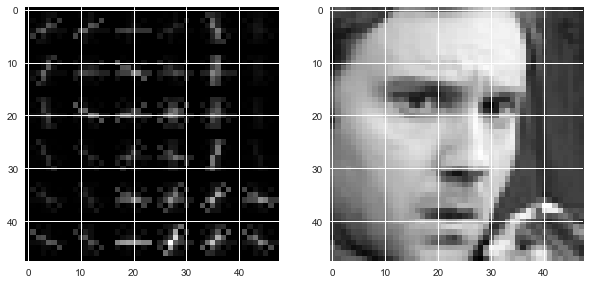

In [31]:
# Plot comparatif entre l'image 0 filtrée HOG et l'image 0 initiale
plt.figure(figsize=(10,10))
plt.subplot(1, 2,1)
plt.imshow(liste_hog[0][0], cmap='gray')
plt.subplot(1,2,2)
plt.imshow(Xtrain[0][0],cmap='gray')
plt.show()

## Filtre Gabor

In [78]:
# Extraction des primitives via filtre de Gabor
Xtrain_gabor = calc_filter_gabor(Xtrain)
Xval_gabor = calc_filter_gabor(Xval)
Xtest_gabor = calc_filter_gabor(Xtest)

liste_gabor = [Xtrain_gabor, Xval_gabor, Xtest_gabor]

# Décommenter pour sauvegarder les primitives dans un fichier npy

# save_dataset(liste_gabor,"GABOR")

Image #0
Image #200
Image #400
Image #600
Image #800
Image #1000
Image #1200
Image #1400
Image #1600
Image #1800
Image #2000
Image #2200
Image #2400
Image #2600
Image #2800
Image #3000
Image #3200
Image #3400
Image #3600
Image #3800
Image #4000
Image #4200
Image #4400
Image #4600
Image #4800
Image #5000
Image #5200
Image #5400
Image #5600
Image #5800
Image #6000
Image #6200
Image #6400
Image #6600
Image #6800
Image #7000
Image #7200
Image #7400
Image #7600
Image #7800
Image #8000
Image #8200
Image #8400
Image #8600
Image #8800
Image #9000
Image #9200
Image #9400
Image #9600
Image #9800
Image #10000
Image #10200
Image #10400
Image #10600
Image #10800
Image #11000
Image #11200
Image #11400
Image #11600
Image #11800
Image #12000
Image #12200
Image #12400
Image #12600
Image #12800
Image #13000
Image #13200
Image #13400
Image #13600
Image #13800
Image #14000
Image #14200
Image #14400
Image #14600
Image #14800
Image #15000
Image #15200
Image #15400
Image #15600
Image #15800
Image #16000
Imag

## Étape 2 : vérification du pouvoir discrimant des primitives

Il y a encore trop de primitives dans chaque ensemble de primitives pour pouvoir visualiser directement. Nous devons donc réduire la dimension pour pourvoir observer. Nous utilisons donc les algorithmes PCA et LDA sur 2 composantes pour visualiser.

### PCA et LDA sur LBP38

explained variance ratio (first two components): [0.01200812 0.0096509 ]


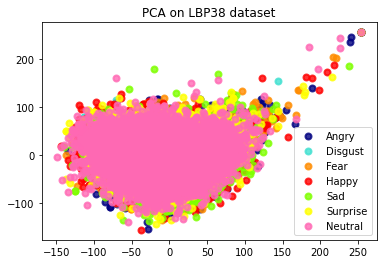

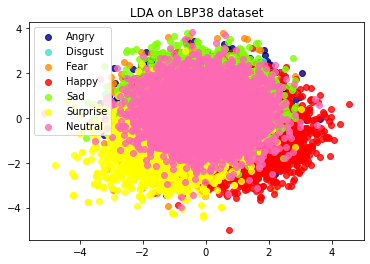

In [23]:
# Vérification via PCA et LDA du pouvoir discriminant des primitives LBP38
# (fonctions implémentée en 5a)

lbp38_train,lbp38_valid,lbp38_test=load_primitive("LBP38")

lbp38_train_pca, pca_lbp38 = reducPCA(lbp38_train, 2)
lbp38_train_lda, lda_lbp38 = reducLDA(lbp38_train, ytrain)

affichagePCA_LDA(pca_lbp38, lbp38_train_pca, lbp38_train_lda, ytrain, "LBP38")

Le pouvoir discriminant est très peu visible en 2D. Distinguer 7 classes avec des caractéristiques aussi proches sur seulement 2 composantes parait compliqué. Il est impossible de conclure avec le PCA, cependant nous remarquons des zones intéressantes sur LDA.

### PCA et LDA sur LBP58

explained variance ratio (first two components): [0.0203155  0.01267915]


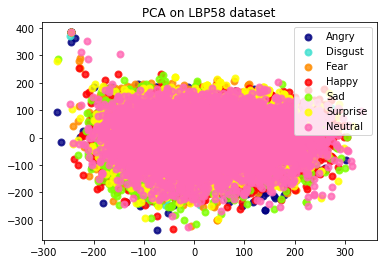

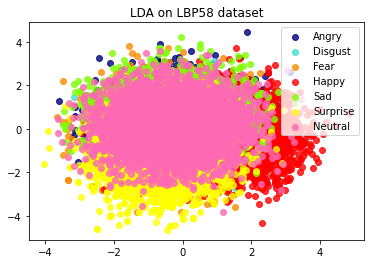

In [24]:
# Vérification via PCA et LDA du pouvoir discriminant des primitives LBP58
# (fonctions implémentée en 5a)

lbp58_train,lbp58_valid,lbp58_test=load_primitive("LBP58")

lbp58_train_pca, pca_lbp58 = reducPCA(lbp58_train, 2)
lbp58_train_lda, lda_lbp58 = reducLDA(lbp58_train, ytrain)

affichagePCA_LDA(pca_lbp58, lbp58_train_pca, lbp58_train_lda, ytrain, "LBP58")

Même résultat que précédemment avec des zones encore plus étendues. Conclusion impossible.

### PCA et LDA sur HOG

/Users/francoisgoujon/miniconda/envs/gti770/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:442: UserWarning: The priors do not sum to 1. Renormalizing
  UserWarning)
/Users/francoisgoujon/miniconda/envs/gti770/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


explained variance ratio (first two components): [ 0.10067161  0.04513948]


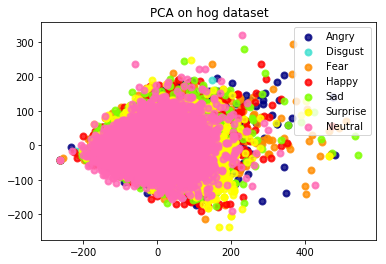

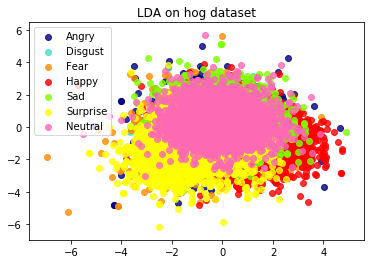

In [38]:
# Vérification via PCA et LDA du pouvoir discriminant des primitives hog
# (fonctions implémentée en 5a)

hog_train,hog_valid,hog_test=load_primitive("hog")

hog_train_pca, pca_hog = reducPCA(hog_train, 2)
hog_train_lda, lda_hog = reducLDA(hog_train, ytrain)

affichagePCA_LDA(pca_hog, hog_train_pca, hog_train_lda, ytrain, "hog")


Les résultats sont semblables aux résultats précédents. Nous retrouvons encore différentes zones en LDA ce qui est intéressant.

### PCA et LDA sur GABOR

In [42]:
gabor_train,gabor_valid,gabor_test=load_primitive("GABOR")
print("Data Loaded")

# On fait un reshape pour avoir le bon nombre de samples, chaque image filtrée avec gabor renvoyant 16 images.
# On utilise les channels pour regrouper les différentes images filtrées
gabor_train_reshaped = concatenatePrimitives(gabor_train, 16)
print(gabor_train_reshaped.shape)
gabor_val_reshaped = concatenatePrimitives(gabor_valid, 16)
print(gabor_val_reshaped.shape)
gabor_test_reshaped = concatenatePrimitives(gabor_test, 16)
print(gabor_test_reshaped.shape)

Data Loaded
(28709, 16, 48, 48)
(3589, 16, 48, 48)
(3589, 16, 48, 48)


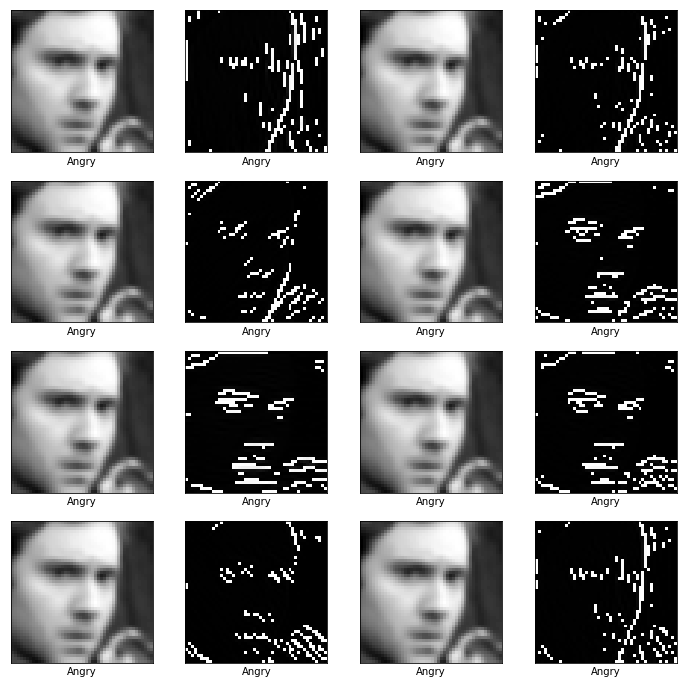

In [34]:
plot_image_grid(X= gabor_train_reshaped[0], y=[ytrain[0]]*16 )
# Plot des différentes versions de l'image 1

In [43]:
# Vérification via PCA et LDA du pouvoir discriminant des primitives GABOR
# (fonctions implémentée en 5a)

# Le nombre d'image étant très grand avec les filtres gabor, nous réduisons le nombre de samples
# pour réduire le temps d'exécution.

gabor_train_pca, pca_gabor = reducPCA(gabor_train_reshaped[0:8000], 2)
print("PCA Complete")
gabor_train_lda, lda_gabor = reducLDA(gabor_train_reshaped[0:8000],ytrain[0:8000])
print("LDA Complete")

PCA Complete
LDA Complete


explained variance ratio (first two components): [0.123094   0.04263349]


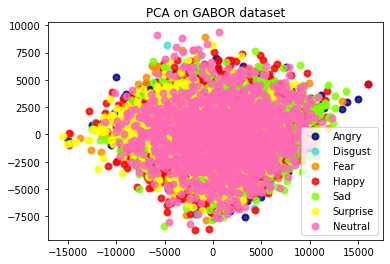

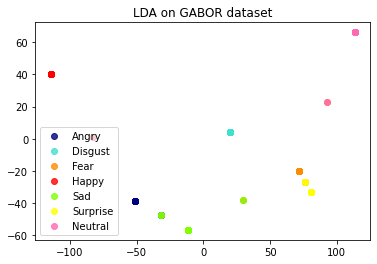

In [46]:
affichagePCA_LDA(pca_gabor, gabor_train_pca[0:8000], gabor_train_lda[0:8000],ytrain[0:8000], "GABOR")

La partie PCA ne permet toujours pas de conclure. Cependant, cette fois-ci la partie LDA est très étonnante avec des groupes très précis. (Ou problème d'affichage ?)

## Conclusion sur les primitives

Nous choisissons les primitives HOG et GABOR qui nous semblent être les plus intéressantes à explorer. Cependant, nous ferons également d'autres test avec les primitives LPB.

## Partie 4: Construction d'un modèle

<font color=blue>Nous sommes maintenant prêtes pour entraîner notre premier modèle avec les primitives extraites dans la partie 3. On suppose que vous avez deux jeux de primitives, alors vous devez entraîner un modèle pour chaque jeu de primitives.</font>

### (4a) Entraîner un modèle

Vous devez choisir un des algorithmes d'apprentissage suivants et l'entraîner sur les données d'apprentissage (même algorithme pour les deux jeux de primitives):<br>
* [Decision trees](https://scikit-learn.org/stable/modules/tree.html) de scikit-learn. <br>
* [k-NN](https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification) de scikit-learn. <br>
* [Naïve Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html) de scikit-learn. 

<font color=blue>Pour ce premier modèle, vous n'est pas supposé de régler (optimiser) votre modèle. Vous allez faire ce réglage dans la partie (4b).</font>

Après l'entraînement, vous devez faire des prédictions sur les données de test.

##### À faire:
1. Entraîner un modèle avec l'algorithme d'apprentissage choisi
2. Classifier tous les exemples (ensembles d'apprentissage, validation et test) et reporter les résultats:<br>
 2a. taux de classification correct sur les trois (3) ensembles de données<br>
 2b. matrice de confusion pour l'ensemble de test
3. <font color=blue>Sauvagarder votre modèle dans un fichier. Regarder [model persistence](https://scikitlearn.org/stable/modules/model_persistence.html?highlight=persistence) </font> 
4. Expliquer pourquoi vous avez choisi cet algorithme d'apprentissage (Q1).
5. Faire une analyse des résultats et présenter vos conclusions sur le modèle entraîné (Q2).
6. Concernant vos primitives, sont-elles discriminantes? (Q3)

### Partie 4a: Code:

In [17]:
# Modele kNN : 

def creationModelekNN(X, ytrain, k=5,weights='uniform') :
    if len(X.shape) == 2 : 
        Xreshape = X.astype('uint8')
    if len(X.shape) == 3 :
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]).astype('uint8')
    if len(X.shape) == 4 : 
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]).astype('uint8') 
    
    neigh = KNeighborsClassifier(n_neighbors=k,weights=weights )
    neigh.fit(Xreshape, ytrain)
    return neigh

# Modele Random Forest

def creationModeleRandomForest(X, ytrain) :
    if len(X.shape) == 2 : 
        Xreshape = X.astype('uint8')
    if len(X.shape) == 3 :
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]).astype('uint8')
    if len(X.shape) == 4 : 
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]).astype('uint8')    
    randomfor = RandomForestClassifier(max_depth=2, random_state=0)
    randomfor.fit(Xreshape, ytrain)
    return randomfor
    
# Fonction de prédiction avec modele

def prediction_avec_modele(modele, X):
    if len(X.shape) == 2 : 
        Xreshape = X.astype('uint8')
    if len(X.shape) == 3 :
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]).astype('uint8')
    if len(X.shape) == 4 : 
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]).astype('uint8') 
    return modele.predict(Xreshape)


### Partie 4a: Résultats et résponses:

## Étape 1 : choix du modèle

Nous testons différents modèles pour trouver les plus performants.

**1NN fit directement sur Xtrain**

In [37]:
# Création du modele 1NN fit sur Xtrain : modele simple pour point de reference du % de bonnes predictions
modele1NN = creationModelekNN(Xtrain_reshaped, ytrain, 1)

In [38]:
# Prédiction des labels sur le set de validation (execution longue)
predictionModele1NN_val = prediction_avec_modele(modele1NN, Xval_reshaped)

In [39]:
# Vérification des résultats du modèle sur le set de validation
comparaison_prediction(predictionModele1NN_val, yval)

Taux de classification correctes : 40.17832265254946%
 Matrice de confusion
[[155  11  48  82  62  26  83]
 [  4  32   2   4   7   0   7]
 [ 42   5 183  72  75  32  87]
 [ 74   4  78 359 112  41 227]
 [ 70  18  63 124 202  22 154]
 [ 21   5  25  51  19 256  38]
 [ 45  12  56 112  96  31 255]]


Résultat satisfaisant pour un modèle aussi simple

**3NN fit directement sur Xtrain**

In [41]:
# Création du modele 3NN fit sur Xtrain : modele simple pour point de reference du % de bonnes predictions
modele3NN = creationModelekNN(Xtrain_reshaped, ytrain, 3)

In [42]:
# Prédiction des labels sur le set de validation (execution longue)
predictionModele3NN = prediction_avec_modele(modele3NN, Xval_reshaped)

In [44]:
# Vérification des résultats du modèle sur le set de validation
comparaison_prediction(predictionModele3NN, yval)

Taux de classification correctes : 33.90916689885762%
 Matrice de confusion
[[178  14  73  90  33  14  65]
 [ 11  25   6   4   4   0   6]
 [ 90  18 173  78  53  31  53]
 [145  22 111 373  68  33 143]
 [151  29  94 146 117  11 105]
 [ 59   8  54  63  20 176  35]
 [103  16  86 144  61  22 175]]


Résultat moins bon qu'avec 1NN

**Modele 3NN avec primitives HOG**

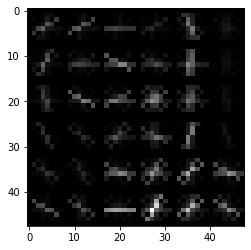

In [13]:
# Récupération des primitives hog
hog_train,hog_valid,hog_test=load_primitive("hog")
plt.imshow(hog_train[0],cmap='gray')
plt.show()

# Création du modele 3NN fit sur les primitives hog
modele3NN_hog = creationModelekNN(hog_train,ytrain,3)

In [54]:
# Vérification des résultats du modèle entraîné avec hog sur le tous les set
# (execution longue)

print_result( modele3NN_hog,hog_train[0:1000],ytrain[0:1000],hog_valid[0:1000],yval[0:1000],hog_test,ytest)


0 /nb_image 1000
250 /nb_image 1000
500 /nb_image 1000
750 /nb_image 1000
train - Taux de classification correctes : 68.8%
0 /nb_image 1000
250 /nb_image 1000
500 /nb_image 1000
750 /nb_image 1000
val - Taux de classification correctes : 39.7%
0 /nb_image 3589
250 /nb_image 3589
500 /nb_image 3589
750 /nb_image 3589
1000 /nb_image 3589
1250 /nb_image 3589
1500 /nb_image 3589
1750 /nb_image 3589
2000 /nb_image 3589
2250 /nb_image 3589
2500 /nb_image 3589
2750 /nb_image 3589
3000 /nb_image 3589
3250 /nb_image 3589
3500 /nb_image 3589
test - Taux de classification correctes : 42.35162998049596%
 Matrice de confusion
[[221  10  63  90  32  21  54]
 [ 12  27   0   8   3   0   5]
 [110   8 201  86  37  30  56]
 [114  15  59 548  44  25  74]
 [138  12  87 130 118  14  95]
 [ 60   7  59  51  22 188  29]
 [128  10  81 136  40  14 217]]


Les résultats avec k = 3 sont déjà très encourageant, un réglage du modèle devrait permettre de d'améliorer le résultat. kNN avec HOG est une bonne combinaison.

**Modele RandomForest avec primitives GABOR**

Le modèle kNN avec GABOR implique des temps d'execution très long étant donné la quantité de données. Nous utilisons donc un modèle randomForest.

In [19]:
# Récupération des primitives GABOR
gabor_train,gabor_valid,gabor_test=load_primitive("GABOR")
print("Data Loaded")

gabor_train_reshaped = concatenatePrimitives(gabor_train, 16)
print(gabor_train_reshaped.shape)
gabor_val_reshaped = concatenatePrimitives(gabor_valid, 16)
print(gabor_val_reshaped.shape)
gabor_test_reshaped = concatenatePrimitives(gabor_test, 16)
print(gabor_test_reshaped.shape)


# Création du modele Random Forest fit sur les primitives GABOR
modeleRF_GABOR = creationModeleRandomForest(gabor_train_reshaped,ytrain)

Data Loaded
(28709, 16, 48, 48)
(3589, 16, 48, 48)
(3589, 16, 48, 48)


In [24]:
# Vérification des résultats du modèle entraîné avec GABOR sur le tous les set

print_result( modeleRF_GABOR,gabor_train_reshaped,ytrain,gabor_val_reshaped,yval,gabor_test_reshaped,ytest,printed=False)

train - Taux de classification correctes : 28.102685568985336%
val - Taux de classification correctes : 24.129283923098356%
test - Taux de classification correctes : 23.794928949568124%
 Matrice de confusion
[[  0   0   0 431  40  20   0]
 [  0   0   0  44   5   5   1]
 [  0   0   0 466  39  20   3]
 [  0   0   0 785  60  29   5]
 [  0   0   0 513  45  27   9]
 [  0   0   0 369  27  20   0]
 [  0   0   0 552  44  26   4]]


Les résultats sont mauvais. Nous remarquons que l'algorithme randomForest est très perturbé par le nombre non uniforme d'élément dans chaque classe. Nous pouvons essayer de les rééquilibrer.

In [30]:
# Nouvel essai avec rééquilibrage 
new_gabor_train_reshaped ,new_ytrain = equilibre_datasets(gabor_train_reshaped,ytrain,3000)
modeleRF_gabor2 = creationModeleRandomForest(new_gabor_train_reshaped,new_ytrain)

In [31]:
print_result( modeleRF_gabor2,gabor_train_reshaped,ytrain,gabor_val_reshaped,yval,gabor_test_reshaped,ytest,printed=False)

train - Taux de classification correctes : 26.66759552753492%
val - Taux de classification correctes : 17.41432153803288%
test - Taux de classification correctes : 17.55363611033714%
 Matrice de confusion
[[ 12   0   0 153 132 164  30]
 [  1   0   0  14  14  20   6]
 [ 24   0   0 162 153 168  21]
 [ 38   0   0 267 246 285  43]
 [ 21   0   0 180 175 196  22]
 [ 11   0   0 132 109 144  20]
 [ 27   0   0 207 159 201  32]]


Le problème d'équilibrage est un peu résorbé mais les résultats sont encore moins bon.

**Modele 3NN avec LBP**

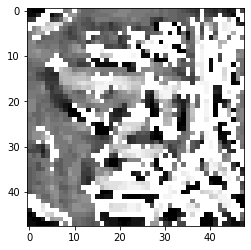

In [27]:
# Récupération des primitives LBP
LBP38_train,LBP38_valid,LBP38_test=load_primitive("LBP38")
plt.imshow(LBP38_train[0],cmap='gray')
plt.show()

# Création du modele 3NN fit sur les primitives LBP38
modele3NN_LBP38 = creationModelekNN(LBP38_train,ytrain,3)

In [17]:
# Vérification des résultats du modèle entraîné avec hog sur le tous les set
# (execution longue)

print_result( modele3NN_LBP38,LBP38_train[0:1000],ytrain[0:1000],LBP38_valid[0:1000],yval[0:1000],LBP38_test,ytest)

0 / 1000
250 / 1000
500 / 1000
750 / 1000
train - Taux de classification correctes : 16.5%
0 / 1000
250 / 1000
500 / 1000
750 / 1000
val - Taux de classification correctes : 17.7%
0 / 3589
250 / 3589
500 / 3589
750 / 3589
1000 / 3589
1250 / 3589
1500 / 3589
1750 / 3589
2000 / 3589
2250 / 3589
2500 / 3589
2750 / 3589
3000 / 3589
3250 / 3589
3500 / 3589
test - Taux de classification correctes : 17.13569239342435%
 Matrice de confusion
[[ 59   2 159 147  97  14  13]
 [ 16   0  11  14  12   1   1]
 [ 61   2 157 151 135  10  12]
 [133   4 259 237 215  20  11]
 [ 69   5 190 185 125  11   9]
 [ 54   4 126 114  90  21   7]
 [103   2 192 186 116  11  16]]


Le modèle 3NN appliqué à la primitive LBP semble être peu performant.

**Modele 1NN avec LBP**

In [28]:
# Récupération des primitives LBP
LBP38_train,LBP38_valid,LBP38_test=load_primitive("LBP38")

# Création du modele 3NN fit sur les primitives LBP38
modele1NN_LBP38 = creationModelekNN(LBP38_train,ytrain,1)

In [30]:
# Vérification des résultats du modèle entraîné avec LBP38 sur le tous les set
# (execution longue)

print_result( modele1NN_LBP38,LBP38_train[0:1000],ytrain[0:1000],LBP38_valid[0:1000],yval[0:1000],LBP38_test,ytest)

train - Taux de classification correctes : 100.0%
val - Taux de classification correctes : 26.8%
test - Taux de classification correctes : 26.219002507662303%
 Matrice de confusion
[[ 71   0 382  13   7   1  17]
 [  0  24  31   0   0   0   0]
 [ 11   0 478  13   6   7  13]
 [  0   0 788  71   1   3  16]
 [  4   0 504  12  51   0  23]
 [  1   0 221  15   0 166  13]
 [  1   0 518  22   3   2  80]]


Le modèle 1NN avec LBP38 est meilleur que le modèle 3NN mais n'est pas très efficace malgré tout.

**Modele RandomForest avec Hog**

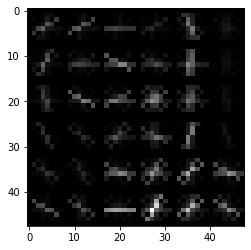

In [12]:
# Récupération des primitives hog
hog_train,hog_valid,hog_test=load_primitive("hog")
plt.imshow(hog_train[0],cmap='gray')
plt.show()

# Création du modele Random Forest fit sur les primitives hog
modeleRF_hog = creationModeleRandomForest(hog_train,ytrain)


In [16]:
print_result( modeleRF_hog,hog_train,ytrain,hog_valid,yval,hog_test,ytest,printed=False)

train - Taux de classification correctes : 27.102999059528372%
val - Taux de classification correctes : 26.44190582334912%
test - Taux de classification correctes : 26.63694622457509%
 Matrice de confusion
[[  0   0   0 464   0   0  27]
 [  0   0   0  51   0   0   4]
 [  0   0   0 485   0   0  43]
 [  0   0   0 869   0   0  10]
 [  0   0   1 565   0   0  28]
 [  0   0   3 348   0   0  65]
 [  0   0   0 539   0   0  87]]


**On remarque que l'algorithme est très réceptif au déséquilibre de classes que nous avons dans le dataset comme prédement. Nous allons donc essayer de l'équilibrer**

Pour cela nous allons faire en sorte que chaque classe contienne le même nombre d'instance, pour cela nous allons fixer ce nombre à 3000 dans train. En effet en observant toutes les classes sauf une possèdent plus de 3000 instances. Nous pourrions aussi considérer le nombre d'instance de disgust qui est la moins représentée, cependant ceci nous amènerait à supprimer trop de données. On préfère ici améliorer les performances de notre algorithme, même si on sacrifie une classe (disgust ici)

In [27]:
new_hog_train,new_ytrain = equilibre_datasets(hog_train,ytrain,3000)

In [28]:
modeleRF_hog2 = creationModeleRandomForest(new_hog_train,new_ytrain)

In [30]:
print_result( modeleRF_hog2,hog_train,ytrain,hog_valid,yval,hog_test,ytest,printed=False)

train - Taux de classification correctes : 34.12518722351876%
val - Taux de classification correctes : 33.296182780718866%
test - Taux de classification correctes : 34.13207021454444%
 Matrice de confusion
[[ 31   0  34 158  14 123 131]
 [  2   0   8  24   1   7  13]
 [ 19   0  45 156  15 178 115]
 [ 15   0  25 594   7  93 145]
 [ 32   0  43 203  31 112 173]
 [  6   0  10  63   4 259  74]
 [ 18   0  27 152  17 147 265]]


**On remarque un gain d'efficacité de 8%, on observe aussi à travers la matrice de confusion, que l'algorithme a prédit presques toutes les classes. Il n'a cependant jamais prédit disgust, qui est la classe désequilibrée. La méthode a donc bien été efficace**

Sachant qu'il y a 500 instances de disgust, on peut aussi tenter de mettre toutes les instances à 500 éléments..

In [31]:
new_hog_train,new_ytrain = equilibre_datasets(hog_train,ytrain,500)

In [32]:
modeleRF_hog2 = creationModeleRandomForest(new_hog_train,new_ytrain)

In [33]:
print_result( modeleRF_hog2,hog_train,ytrain,hog_valid,yval,hog_test,ytest,printed=False)

train - Taux de classification correctes : 33.95799226723327%
val - Taux de classification correctes : 33.6862635831708%
test - Taux de classification correctes : 33.825578155475064%
 Matrice de confusion
[[ 29  31  12 153  43 141  82]
 [  4  14   1  19   4   9   4]
 [ 21  32  18 154  40 184  79]
 [ 21  17   8 618  54  86  75]
 [ 27  28  17 211  78 115 118]
 [ 10  15   2  58  13 262  56]
 [ 15  33   5 183  63 132 195]]


Nous remarquons ici que l'algorithme a bien prédit des classes disgust. Ainsi l'algorithme semble etre sensible à l'équilibre des classes. L'efficacité est similaire, selon ce que nous voulons réaliser avec l'algorithme, nous pourrons préférer l'une ou l'autre de ces solutions.

**Modele RandomForest avec LBP38**

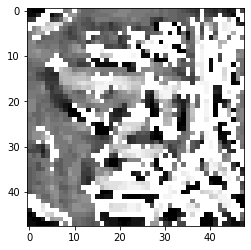

In [31]:
# Récupération des primitives LBP38
LBP38_train,LBP38_valid,LBP38_test=load_primitive("LBP38")
new_LBP38_train,new_ytrain = equilibre_datasets(LBP38_train,ytrain,3000)
plt.imshow(LBP38_train[0],cmap='gray')
plt.show()

# Création du modele Random Forest fit sur les primitives LBP38
modeleRF_LBP38 = creationModeleRandomForest(new_LBP38_train,new_ytrain)

In [32]:
print_result( modeleRF_LBP38,LBP38_train,ytrain,LBP38_valid,yval,LBP38_test,ytest,printed=False)

train - Taux de classification correctes : 31.739175868194643%
val - Taux de classification correctes : 30.872109222624687%
test - Taux de classification correctes : 31.178601281694064%
 Matrice de confusion
[[ 81   0   6 154  53  88 109]
 [  6   0   0  23   4  13   9]
 [ 58   0   8 196  52 116  98]
 [ 75   0   8 505  72 114 105]
 [ 82   0   3 190  82  77 160]
 [ 18   0   5  98  24 195  76]
 [ 42   0   3 170  59 104 248]]


Résultats moyen comparés aux autres mais encore des problèmes avec l'équilibrage malgré un rééquilibrage.

**Modele RandomForest avec LBP58**

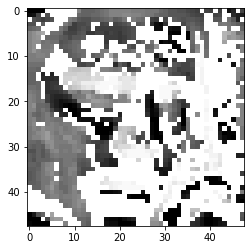

In [33]:
# Récupération des primitives LBP58
LBP58_train,LBP58_valid,LBP58_test=load_primitive("LBP58")
new_LBP58_train,new_ytrain = equilibre_datasets(LBP58_train,ytrain,750)
plt.imshow(LBP58_train[0],cmap='gray')
plt.show()

# Création du modele Random Forest fit sur les primitives LBP58
modeleRF_LBP58 = creationModeleRandomForest(new_LBP58_train,new_ytrain)

In [34]:
print_result( modeleRF_LBP58,LBP58_train,ytrain,LBP58_valid,yval,LBP58_test,ytest,printed=False)

train - Taux de classification correctes : 31.91333728099202%
val - Taux de classification correctes : 30.872109222624687%
test - Taux de classification correctes : 31.15073836723321%
 Matrice de confusion
[[ 63   0  22 123 125  49 109]
 [  7   0   3  25   8   5   7]
 [ 54   0  19 155 126  83  91]
 [ 85   0  28 472 123  72  99]
 [ 67   0  21 129 184  51 142]
 [ 27   0  13  93  69 133  81]
 [ 43   0  22 154 101  59 247]]


L'utilisation de la primitive LBP58 n'améliore pas les résultats.

#### Vos résultats ici:

##### Exemple:

| Ensemble | Taux de classification correct |                               
|----------|--------------------------------|
| App      | 99,67%                         |                   
| Val      | 89,77%                         |                             
| Test     | 77,99%                         |        

Q1: Nous avons choisi l'algorithme ... parce que...

Q2: Les taux de classification indiquent que le modèle...

Q3: La performance avec le primitive...

Q1: Nous avons choisi l'algorithme kNN parce que ce dernier présente les meilleur taux de classification correct :

| Ensemble | Taux de classification correct |                               
|----------|--------------------------------|
| App      | 68.8%                          |                   
| Val      | 39.7%                          |                             
| Test     | 42.3%                          |  

Cependant cet algorithme est très long lors de la prédiction, ceci semble normal au vu de la taille du dataset : En effet on mesure ici les distances du point que l'on veut étudier avec l'ensemble du dataset de train. L'algortithme random forest est bien plus rapide cependant il présente de moins bons résultats ce qui ne le rend pas utilisable avec notre dataset.


Q2: Les taux de classification indiquent que le modèle semble être meilleur que notre baseline : le taux sur l'ensemble de test passe de 22% à 42% ce qui est presque 2 fois plus. Ajouté à cela notre modèle présente une bonne efficacité sur son ensemble de train : 69%, qui est très différent de son efficacité sur les 2 autres ensembles. On peut donc supposer que notre algorithme a un peu de mal à généraliser. La modification de l'hyperparamètre K peut permettre de palier à ce problème.

Q3: La performance avec le primitive hog semble être bien meilleure qu'avec LBP. La primitive gabor, est trop volumineuse, ainsi sa complexité temporelle est trop grande. En comparant les résultats obtenus entre les diverses primitives ont peut bien penser que la primitive hog est discrimante, en effet celle-ci améliore les prédictions. 
On peut aussi comparer notre modèle à notre baseline pour cela : la baseline que nous avions s'apparentait à un kNN, cependant les résultats issus de notre nouvel algorithme sont bien meilleur, ce qui nous laisse supposer de la qualité du filtre hog dans cette étude.
Nous conserverons donc la primitive de hog.

**Nous n'avons pas jugé intéressant de sauvegarder nos modèles : en effet les algorithmes que nous utilisons sont très rapides à entrainer. Ce qui peut prendre du temps serait plutôt la prédiction.**

### (4b) Réglage du modèle

Probablement vous avez outperformé le modèle << baseline >>, mais est-ce qu'on peut mieux performer? Est-ce qu'on peut faire un << fine-tuning >> de notre modèle? Quels sont les paramètres que vous pouvez ajuster pour améliorer la performance?

##### À faire:
1. Lister les principaux paramètres de votre modèle qui peuvent aider à améliorer sa performance.
2. Choisir quelques paramètres (au moins 2) et tourner un << grid search>> pour trouver les meilleures valeurs pour ces paramètres.
3. Une fois que vous avez trouvé le meilleur modèle, utiliser ce modèle pour classifier tous les exemples (apprentissage, validation, test) et reporter les résultats:<br>
 3a. taux de classification correct sur les 3 ensembles<br>
 3b. matrice de confusion pour l'ensemble de test
4. Explique pourquoi vous avez choisi ces paramètres.
5. Faire une analyse des résultats et présenter vos conclusions sur ce modèle << fine- tuned >>

### Partie 4b: Code:

Nous ferons varier les paramètres k, et weights : 
- k : Nombre de voisins à utiliser pour prédire la classe
- weights {‘uniform’, ‘distance’} : fonction de poids utilisée dans la prédiction  

En effet ces paramètres semblent à notre goût être des paramètres intéressants à faire varier : k est un paramètre essentiel du kNN il permet de mieux généraliser. Un mauvais choix de K peut entrainer de l'overfitting. Quant aux poids, leur ajout peut permettre de réduire l'impact de points distants.

D'autres paramètres existent : 
- algorithm {‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’} : Algorithme utilisé pour calculer les voisins les plus proches:
- leaf_size : Taille des feuilles transmise à BallTree ou KDTree
- p : Paramètre de puissance pour la métrique de Minkowski. Lorsque p = 1, cela équivaut à utiliser manhattan_distance (l1) et euclidean_distance (l2) pour p = 2. Pour p arbitraire, minkowski_distance (l_p) est utilisé.
- metric : la métrique de distance à utiliser pour l'arbre ( par défaut = 'minkowski' )

Nous pouvons aussi essayer d'équilibrer le dataset afin d'améliorer nos résultats, cependant nos précédentes expériences nous ont montrés que le random forest était très sensible à l'équilibre des classes, mais que le Knn semblait peu l'être ( au vu des matrices de confusion ).


In [28]:
def eval_acc(model,data,label):
    if len(data.shape) == 2 : 
        dataReshape = data.astype('uint8')
    if len(data.shape) == 3 :
        dataReshape = data.reshape(data.shape[0], data.shape[1]*data.shape[2]).astype('uint8')
    if len(data.shape) == 4 : 
        dataReshape = data.reshape(data.shape[0], data.shape[1]*data.shape[2]*data.shape[3]).astype('uint8') 
    preds=model.predict(dataReshape)
    
    nb_correctes = 0
    nb_fausses = 0
    nb_images = len(preds)
    for i in range(nb_images):
        if preds[i]==label[i]:
            nb_correctes += 1
        else :
            nb_fausses += 1
        
    return (nb_correctes/nb_images)*100

In [29]:
#fonction testant divers hyperparamètres
def search_hyperparam(Xtrain,ytrain,Xval,yval):
    list_weights = {"uniform", "distance"}
    list_k = range(1,10)
    results={}
    
    for weights in list_weights :
        print("switch to weights : ",weights)
        for k in list_k:
            print("switch to k : ",k)
            
            
            current_modeleKNN = creationModelekNN(Xtrain, ytrain, k,weights)
            
            acc = eval_acc(current_modeleKNN,Xval,yval)
            print(acc)
            results[str(k) + " " + weights] = acc
    max_acc,best_hyperpar=0, ""
    for key, value in results.items():
        if value > max_acc : 
            max_acc = value
            best_hyperpar = key
    print("best hyperparams : ",best_hyperpar," with an accuracy on validation set : ",max_acc)
    
            
   

### Partie 4b: Résultats et résponses:

In [28]:
# Vos résultats ici:
hog_train,hog_valid,hog_test=load_primitive("hog")
search_hyperparam(hog_train,ytrain,hog_valid,yval)

switch to weights :  distance
switch to k :  1
46.53106714962385
switch to k :  2
46.558930064084706
switch to k :  3
46.78183337977153
switch to k :  4
46.336026748397884
switch to k :  5
45.5001393145723
switch to k :  6
45.63945388687657
switch to k :  7
45.80663137364168
switch to k :  8
45.55586514349401
switch to k :  9
45.695179715798275
switch to weights :  uniform
switch to k :  1
46.53106714962385
switch to k :  2
41.432153803287825
switch to k :  3
41.01421008637504
switch to k :  4
40.54054054054054
switch to k :  5
40.791306770688216
switch to k :  6
40.23404848147116
switch to k :  7
40.401225968236275
switch to k :  8
40.23404848147116
switch to k :  9
40.15045973808861
best hyperparams :  9 uniform  with an accuracy on validation set :  40.15045973808861


La dernière ligne est fausse. Le meilleur couple d'hyperparamètre trouvé est k = 3 et weights = distance. Avec cela nous avons obtenu 46,8% de bonnes évaluations sur le validation set. Finalement après avoir choisi nos hyperparamètres sur le validation set nous comparons notre modèle avec notre baseline à l'aide du test set.

In [73]:
hog_train,hog_valid,hog_test=load_primitive("hog")
model_tuned = creationModelekNN(hog_train, ytrain, 3,"distance")

In [32]:
print_result( model_tuned,hog_train[0:1000],ytrain[0:1000],hog_valid[0:1000],yval[0:1000],hog_test,ytest,printed=False)
#on ne mesure que les 1000 premières image sur le dataset de train et de validation car le temps de prédiction est trop long. 


train - Taux de classification correctes : 100.0%
val - Taux de classification correctes : 45.800000000000004%
test - Taux de classification correctes : 48.31429367511842%
 Matrice de confusion
[[173   8  50  96  50  35  79]
 [  4  35   1   5   4   0   6]
 [ 53   3 219  77  56  39  81]
 [ 43   9  46 561  73  34 113]
 [ 59   6  54 126 186  28 135]
 [ 22   3  23  40  16 274  38]
 [ 58   5  56 125  68  28 286]]


**Au vu de la matrice de confusion on peut aussi essayer d'équilibrer les datasets. Nous fixons le nombre d'instance de chaque classe à 1500. Ceci peut sembler être un bon compromis entre les résultats obtenus précédemment.**

In [33]:
new_hog_train,new_ytrain = equilibre_datasets(hog_train,ytrain,1500)

In [34]:
model_tuned = creationModelekNN(new_hog_train, new_ytrain, 3,"distance")

print_result( model_tuned,hog_train[0:1000],ytrain[0:1000],hog_valid[0:1000],yval[0:1000],hog_test,ytest,printed=False)

train - Taux de classification correctes : 100.0%
val - Taux de classification correctes : 34.8%
test - Taux de classification correctes : 36.66759543048203%
 Matrice de confusion
[[143  22  61  76  62  53  74]
 [  2  38   2   5   1   1   6]
 [ 58  22 161  66  68  60  93]
 [ 85  34  65 364 102  80 149]
 [103  17  63  99 147  46 119]
 [ 25  12  40  26  32 234  47]
 [ 87  21  51  97  80  61 229]]


Le résultat est moins bon, nous conserverons l'algorithme précédent.

| Ensemble | Taux de classification correct (fine-tuned) | Taux de classification correct (before fine-tuning) |                                
|----------|---------------------------------------------|-----------------------------------------------------|
| App      | 100.0%                                      |68.8%                                                |               
| Val      | 46,8%                                       |39.7%                                                |             
| Test     | 48.3%                                       |42.3%                                                |  

On observe que le modèle fine tuned présente une bien meilleure précision sur les données d'entraînement, en effet la distance entre le point que l'on cherche à prédire de ce dataset et lui-même est nulle. Son "vote" pour définir sa classe est donc fortement impacté par lui-même. La précision de 100% semble être assez logique. 
Nous avons aussi gagné en précision sur les autres datasets. En particulier sur le set de test, on a un gain de 6% ce qui est très intéressant.



## Partie 5: Réduction de la dimensionnalité

### Bibliotèques Python pour la reduction de la dimensionnalité

* [Transformation algorithms](https://scikit-learn.org/stable/modules/decomposition.html#decompositions)
* [Feature selection algorithms](https://scikit-learn.org/stable/modules/feature_selection.html)

##### À faire:
1. Choisir un algorithme de transformation de primitives et un algorithme de sélection des primitives et réduire la dimensionnalité de vos vecteurs de primitives (Partie 3).
2. Choisir les deux meilleures primitives et ploter un graphique pour visualiser si ces primitives sont capables de bien séparer les sept (7) classes.
3. Faire une analyse des résultats et présenter vos conclusions sur ces primitives.

### Partie 5a: Code:

In [20]:
# Fonction de réduction des primitives sur 2 composantes via PCA
"""If n_components == 'mle' and svd_solver == 'full',
Minka’s MLE is used to guess the dimension.
Use of n_components == 'mle' will interpret svd_solver == 'auto' as svd_solver == 'full'.

If 0 < n_components < 1 and svd_solver == 'full',
select the number of components such that the amount of variance that needs
to be explained is greater than the percentage specified by n_components."""

def reducPCA(X, components, svd_solver='auto') :
    if len(X.shape) == 2 : 
        Xreshape = X.astype('uint8')
    if len(X.shape) == 3 :
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]).astype('uint8')
    if len(X.shape) == 4 : 
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]).astype('uint8')
    pca = PCA(n_components=components, svd_solver = svd_solver)
    X_pca = pca.fit(Xreshape).transform(Xreshape)
    
    return X_pca, pca

# Fonction de réduction des primitives sur 2 composantes via LDA
# attention le dateset X doit être au format X[samples][width][height]

def reducLDA(X, y, components=2) :
    if len(X.shape) == 2 : 
        Xreshape = X.astype('uint8')
    if len(X.shape) == 3 :
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]).astype('uint8')
    if len(X.shape) == 4 : 
        Xreshape = X.reshape(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3]).astype('uint8')
    lda = LinearDiscriminantAnalysis(n_components=components)
    X_lda = lda.fit(Xreshape, y).transform(Xreshape)
    
    return X_lda, lda

# Fonction d'affichage du PCA des primitives en 2D

def affichagePCA(pca, train_pca, ytrain, nomdonnee="FER"):
    # Pourcentage de variance expliqué par chaque composante
    print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

    plt.figure()
    colors = ['navy', 'turquoise', 'darkorange', 'red', 'chartreuse', 'yellow', 'hotpink']
    lw = 2

    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5 , 6], labels):
        plt.scatter(train_pca[ytrain == i, 0], train_pca[ytrain == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title("PCA on " + nomdonnee + " dataset")

    plt.show()
    
    
# Fonction d'affichage du LDA des primitives en 2D

def affichageLDA(train_lda, ytrain, nomdonnee="FER"):
    plt.figure()
    colors = ['navy', 'turquoise', 'darkorange', 'red', 'chartreuse', 'yellow', 'hotpink']
    lw = 2
    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5, 6], labels):
        plt.scatter(train_lda[ytrain == i, 0], train_lda[ytrain == i, 1], alpha=.8, color=color,
                label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title("LDA on " + nomdonnee + " dataset")

    plt.show()

# Fonction d'affichage du PCA et LDA des primitives en 2D

def affichagePCA_LDA(pca, train_pca, train_lda, ytrain, nomdonnee="FER"):
    # Pourcentage de variance expliqué par chaque composante
    print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

    plt.figure()
    colors = ['navy', 'turquoise', 'darkorange', 'red', 'chartreuse', 'yellow', 'hotpink']
    lw = 2

    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5 , 6], labels):
        plt.scatter(train_pca[ytrain == i, 0], train_pca[ytrain == i, 1], color=color, alpha=.8, lw=lw,
                label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title("PCA on " + nomdonnee + " dataset")

    plt.figure()
    for color, i, target_name in zip(colors, [0, 1, 2, 3, 4, 5, 6], labels):
        plt.scatter(train_lda[ytrain == i, 0], train_lda[ytrain == i, 1], alpha=.8, color=color,
                label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title("LDA on " + nomdonnee + " dataset")

    plt.show()

### Partie 5a: Résultats et résponses et partie 5b : Rentraîner le modèle de la partie 4a

Vous devez rentraîner le modèle et l'entraîner sur les données d'apprentissage.<br>
Après l'entraînement, vous devez faire des prédictions sur les données de test.

#### Nous avons joins les parties 5a et 5b pour plus de cohérence dans la lecture du notebook.

### PCA et LDA sur Xtrain

explained variance ratio (first two components): [0.28923892 0.09806088]


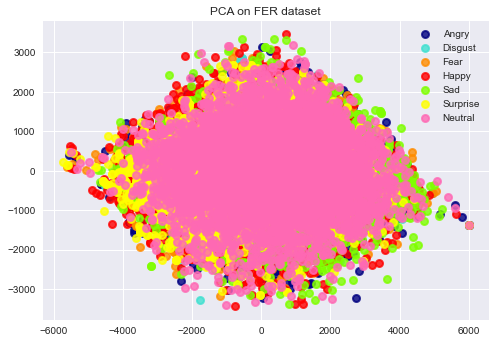

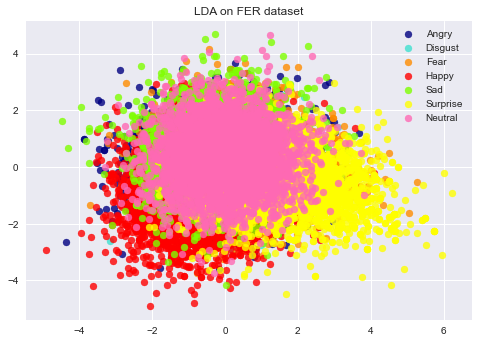

In [57]:
# Réduction de dimensionalité directement sur Xtrain : 

Xtrain_pca, pca = reducPCA(Xtrain_reshaped, 2)
Xtrain_lda, lda = reducLDA(Xtrain_reshaped, ytrain)

affichagePCA_LDA(pca, Xtrain_pca, Xtrain_lda, ytrain)

Très peu de discrimination possible : cohérent les données ne sont pas traitées.

### Entraînement d'un modèle fit sur les 2 primitives renvoyées par PCA sur 2 composantes sur HOG

explained variance ratio (first two components): [0.10067161 0.04513949]


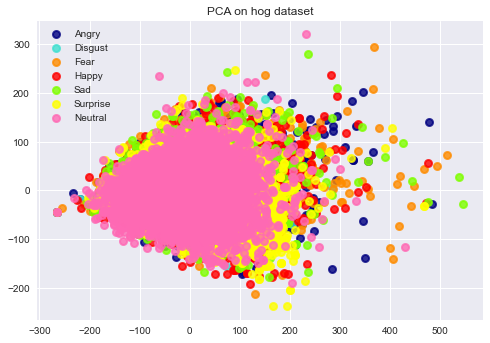

In [58]:
# Reduction de dimension sur les primitives HOG à 2 dimensions avec PCA

hog_train,hog_valid,hog_test=load_primitive("hog")

hog_train_pca, pca_hog = reducPCA(hog_train, components=2)

affichagePCA(pca_hog, hog_train_pca, ytrain, "hog")


In [59]:
# Modele choisi dans la partie precedente avec dimension réduite
model_hog_pca= creationModelekNN(hog_train_pca, ytrain, 3,"distance")

In [60]:
hog_valid_reshaped = hog_valid.reshape(hog_valid.shape[0], hog_valid.shape[1]*hog_valid.shape[2]).astype('uint8')
hog_valid_pca = pca_hog.transform(hog_valid_reshaped)

hog_test_reshaped = hog_test.reshape(hog_test.shape[0], hog_test.shape[1]*hog_test.shape[2]).astype('uint8')
hog_test_pca = pca_hog.transform(hog_test_reshaped)

In [61]:
print_result( model_hog_pca,hog_train_pca,ytrain,hog_valid_pca,yval,hog_test_pca,ytest,printed=False)

train - Taux de classification correctes : 79.13546274687381%
val - Taux de classification correctes : 23.042630259125104%
test - Taux de classification correctes : 22.34605739760379%
 Matrice de confusion
[[119   9  69 124  74  31  65]
 [ 12  13   6   9   7   3   5]
 [100   4 136 118  58  44  68]
 [160  17 159 241 121  70 111]
 [120  18 117 148  80  47  64]
 [ 62  10  65  87  41 115  36]
 [100   9 101 182  85  51  98]]


Les résultat sont beaucoup moins bons que lorsque nous avons l'intégralité de HOG.

### Entraînement d'un modèle fit sur les 2 primitives renvoyées par LDA sur 2 composantes sur HOG

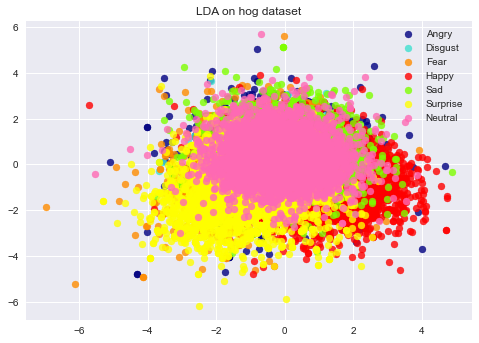

In [62]:
# Reduction de dimension sur les primitives HOG à 2 dimensions avec LDA
#hog_train,hog_valid,hog_test=load_primitive("hog")
hog_train_lda, lda_hog = reducLDA(hog_train, ytrain, components=2)

affichageLDA(hog_train_lda, ytrain, "hog")

In [63]:
# Modele choisi dans la partie precedente avec dimension réduite
model_hog_lda= creationModelekNN(hog_train_lda, ytrain, 3,"distance")

In [64]:
hog_valid_lda = lda_hog.transform(hog_valid_reshaped)
hog_test_lda = lda_hog.transform(hog_test_reshaped)

In [65]:
print_result( model_hog_lda,hog_train_lda,ytrain,hog_valid_lda,yval,hog_test_lda,ytest,printed=False)

train - Taux de classification correctes : 25.128008638406072%
val - Taux de classification correctes : 24.82585678461967%
test - Taux de classification correctes : 24.324324324324326%
 Matrice de confusion
[[156   0 256  42  15  13   9]
 [ 20   0  23  10   0   2   0]
 [183   0 234  40  24  32  15]
 [117   0 385 357   1  16   3]
 [204   0 290  61  21   4  14]
 [113   0 164  14  23  96   6]
 [185   0 376  38  13   5   9]]


Les résultats sont toujours moins bons qu'avec l'intégralité des primitives mais meilleurs qu'avec PCA.

### Entraînement d'un modèle fit sur les n primitives renvoyées par PCA avec méthode mle pour trouver le bon nombre de composantes, sur HOG

In [21]:
# Reduction de dimension sur les primitives HOG avec PCA méthode du coude

hog_train,hog_valid,hog_test=load_primitive("hog")

hog_train_pca_mle, pca_hog_mle = reducPCA(hog_train, components='mle')
print(hog_train_pca_mle.shape)
print(pca_hog_mle.explained_variance_ratio_)

(28709, 540)
[1.00671609e-01 4.51394919e-02 3.60870609e-02 3.13648320e-02
 2.99547506e-02 2.73591855e-02 2.51348996e-02 2.46589263e-02
 2.26478846e-02 2.20609637e-02 1.72391745e-02 1.70436022e-02
 1.56245587e-02 1.54166814e-02 1.46803565e-02 1.36765789e-02
 1.30373849e-02 1.26477481e-02 1.14878185e-02 1.10123279e-02
 1.08807490e-02 1.02352287e-02 1.01909410e-02 9.80499145e-03
 9.45149110e-03 9.12672147e-03 9.08914366e-03 8.63783206e-03
 8.42929410e-03 8.18025459e-03 7.95321310e-03 7.85261714e-03
 7.57266949e-03 7.40627073e-03 7.27740777e-03 7.15582644e-03
 6.95569606e-03 6.75470642e-03 6.61893118e-03 6.52953483e-03
 6.32900310e-03 6.17380112e-03 6.04042912e-03 6.01944465e-03
 5.81334056e-03 5.58793299e-03 5.51051042e-03 5.31139548e-03
 5.24298888e-03 5.20084400e-03 5.05502641e-03 4.96636772e-03
 4.92151850e-03 4.77874080e-03 4.69300240e-03 4.57223951e-03
 4.49566071e-03 4.44795839e-03 4.29960603e-03 4.25148276e-03
 4.17083664e-03 4.10192242e-03 4.08783076e-03 4.02093902e-03
 3.90527328

In [22]:
# Modele choisi dans la partie precedente avec dimension réduite
model_hog_pca_mle= creationModelekNN(hog_train_pca_mle, ytrain, 3,"distance")

In [24]:
hog_valid_pca_mle =  pca_hog_mle.transform(hog_valid.reshape(hog_valid.shape[0], hog_valid.shape[1]*hog_valid.shape[2]).astype('uint8'))
hog_test_pca_mle = pca_hog_mle.transform(hog_test.reshape(hog_test.shape[0], hog_test.shape[1]*hog_test.shape[2]).astype('uint8'))

In [25]:
print(hog_train_pca_mle.shape)
print(hog_valid_pca_mle.shape)
print(hog_test_pca_mle.shape)

(28709, 540)
(3589, 540)
(3589, 540)


**On remarque que l'algorithme réduit à 540 dimensions**

In [26]:
print_result( model_hog_pca_mle,hog_train_pca_mle,ytrain,hog_valid_pca_mle,yval,hog_test_pca_mle,ytest,printed=False)

train - Taux de classification correctes : 99.84673795673831%
val - Taux de classification correctes : 38.562273613820004%
test - Taux de classification correctes : 38.25578155475063%
 Matrice de confusion
[[170   6  56  77  75  31  76]
 [  4  35   1   5   4   2   4]
 [ 57   4 218  79  84  38  48]
 [ 95  11 106 315 146  82 124]
 [ 72   7  91 112 195  34  83]
 [ 26   1  31  54  32 233  39]
 [ 67   5  79 124  87  57 207]]


On remarque que les résultats sont très bons sur le set de train et que les résultats sur les 2 autres sets sont intéressants

### (5b) Rentraîner le modèle de la partie 4a

Vous devez rentraîner le modèle et l'entraîner sur les données d'apprentissage.<br>
Après l'entraînement, vous devez faire des prédictions sur les données de test.

### Partie 5b: Code:

Compris dans la partie 5a.

### Partie 5b: Résultats et résponses:

Compris dans la partie 5a.

### (5c) Réglage du modèle

Vous devez reoptimiser votre nouveau modèle et l'entraîner sur les données d'apprentissage.
Après l'entraînement, vous devez faire des prédictions sur les données de test.

### Partie 5c: Code:

In [ ]:
# Votre code ici

### Partie 5c: Résultats et résponses:

In [30]:
# Vos résultats ici
search_hyperparam(hog_train_pca_mle,ytrain,hog_valid_pca_mle,yval)




switch to weights :  distance
switch to k :  1
38.61799944274171
switch to k :  2
38.61799944274171
switch to k :  3
38.562273613820004
switch to k :  4
37.392031206464196
switch to k :  5
37.72638617999443
switch to k :  6
37.754249094455275
switch to k :  7
37.809974923376984
switch to k :  8
37.19699080523823
switch to k :  9
37.19699080523823
switch to weights :  uniform
switch to k :  1
38.61799944274171
switch to k :  2
33.51908609640568
switch to k :  3
32.98969072164948
switch to k :  4
33.07327946503204
switch to k :  5
33.40763443856227
switch to k :  6
33.07327946503204
switch to k :  7
33.49122318194483
switch to k :  8
32.82251323488437
switch to k :  9
32.543884090275846
best hyperparams :  1 distance  with an accuracy on validation set :  38.61799944274171


On retrouve un résultat similaire vis-à-vis du réglage des hyperparamètres : k=1 et weights = distance. Cependant le modèle présente 10% de perte d'efficacité ce qui n'est pas négligeable.

## Partie 6: Analyse qualitative

Choisir dans l'ensemble de test, exemples de visages bien et mal classifié et montrer ces exemples avec la vraie étiquette et la prédiction faite par votre meilleur modèle.

In [40]:
# Fonction permettant d'afficher des exemples de visages du set test avec la prédiction et le vrai label
def randomExempleTest(Xtest, ytest, prediction, num_rows=4, num_cols=4, nb_images_to_show=16):    
    # Number of images to plot (from the beginning)
    num_images = num_rows*num_cols    
    
    # Width and height in inches for images in the grid
    plt.figure(figsize=(3*num_rows, 3*num_rows))
    
    taille = Xtest.shape[0]
    
    # Iterate over images
    for i in range(nb_images_to_show):
        indice = random.randint(0, taille -1)
        plt.subplot(num_rows, num_cols, i+1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(Xtest[indice].reshape(HEIGHT, WIDTH), cmap='gray')  # Plot image
        plt.xlabel(f"Label : {labels[ytest[indice]]} \n Prédiction : {labels[prediction[indice]]}")  # Plot label
    plt.show()

## Appel de la fonction précédente sur le modèle final ( modèle optimisé )

In [32]:
hog_train,hog_valid,hog_test=load_primitive("hog")
model_tuned = creationModelekNN(hog_train, ytrain, 3,"distance")

In [34]:
preds=model_tuned.predict(hog_test.reshape(hog_test.shape[0], hog_test.shape[1]*hog_test.shape[2]).astype('uint8')[:1000])

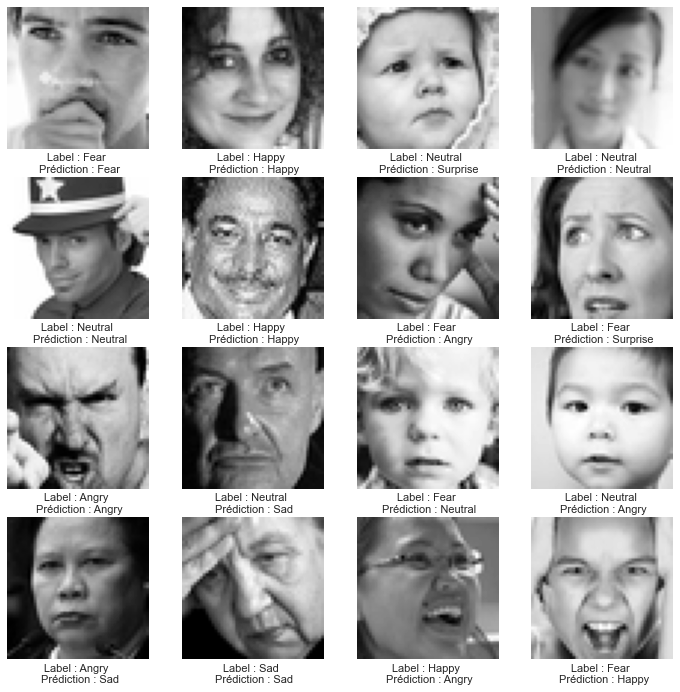

In [45]:
randomExempleTest(Xtest_reshaped[:1000], ytest[:1000], preds)

Nous vérifions les prédictions d'images aléatoirement choisies dans le set de test :
Nous remarquons que les labels attribués à certaines images sont discutables. En effet, sur certaines images différents choix semblent possibles parmis : Angry, Disgust, Fear, Happy, Sad, Surprise, Neutral <br/>

Photo 1 : Le label fear n'est pas évident à l'oeil mais tout de même bien prédit.  <br/>
Photo 2 : Prédiction correcte : Le sourire rend le label happy évident. <br/>
Photo 3 : Prédiction incorrecte : Les sourcils abaissés peuvent faire penser à un état de surprise. On peut penser que l'enfant est surpris par ce qu'il vient de voir. La prédiction ne parait donc pas si mauvaise. <br/>
Photo 4 : Photo floue mais le label est tout de même bien prédit. La personne semble sourire ce qui aurait pu être interprété comme happy. <br/>
Photo 5 : Malgré les habits et le couvre chef visible sur la photo le modele a bien prédit le label. <br/>
Photo 6 : Prédiction correcte : Le sourire rend le label happy évident. <br/>
Photo 7 : Prédiction incorrecte : Sur cette image le label fear est attribué alors que le modele prédit angry. Nous trouvons dans ce cas que l'image présente plus une personne énervée qu'apeurée. La prédiction du modele nous semble donc cohérente. <br/>
Photo 8 : Prédiction incorrecte : Le label fear est évident ici et notre modele se trompe donc réellement. Cela est probablement dûe à la bouche de la personne qui est ouverte. Ce comportement est récurent dans les images labélisées surprise. <br/>
Photo 9 : Prédiction correcte : Le label angry est ici aussi évident. Modele non perturbé par la main au premier plan.<br/>
Photo 10 : Prédiction incorrecte : Le label neutral parait effectivement le plus approprié ici. L'erreur pourrait être dûe par les yeux qui regardent en l'air.<br/>
Photo 11 : Prédiction incorrecte : L'enfant semble effectivement apeuré cependant ceci est peu visible via ses traits qui reste neutres. L'erreur semble donc cohérente avec des primitives hog.<br/>
Photo 12 : Prédiction incorrecte : erreur assez grossière ici.<br/>
Photo 13 : Prédiction incorrecte : Le regard de la personne semble assez énervé ici cependant le choix de label sad parait envisageable.<br/>
Photo 14 : Prédiction correcte : Le label sad est évident ici.<br/>
Photo 15 : Prédiction incorrecte : erreur assez grossière ici. <br/>
Photo 16 : Prédiction incorrecte : Le label fear est très visible ici ce qui fait que l'erreur peu paraître assez grossière dans un premier temps ici cependant nous reconnaissons de la peur ici principalement grâce aux mains placées au niveau des tempes. Sans celle ci nous pourrions penser que l'enfant crie de joie. Ceci explique sans doute l'erreur.<br/>

Nous remarquons donc que sur 16 images à prédire 7 prédictions sont correctes, 4 sont grossièrement incorrecte et 5 autre sont incorrectes mais la prédiction du modele reste cohérente avec l'image.<br/>

Nous remarquons donc 55% d'erreur sur cet essai mais seulement 25% d'erreurs évidentes. Ce résultat est donc bon à notre vue.

**Nous faisons un second essai**

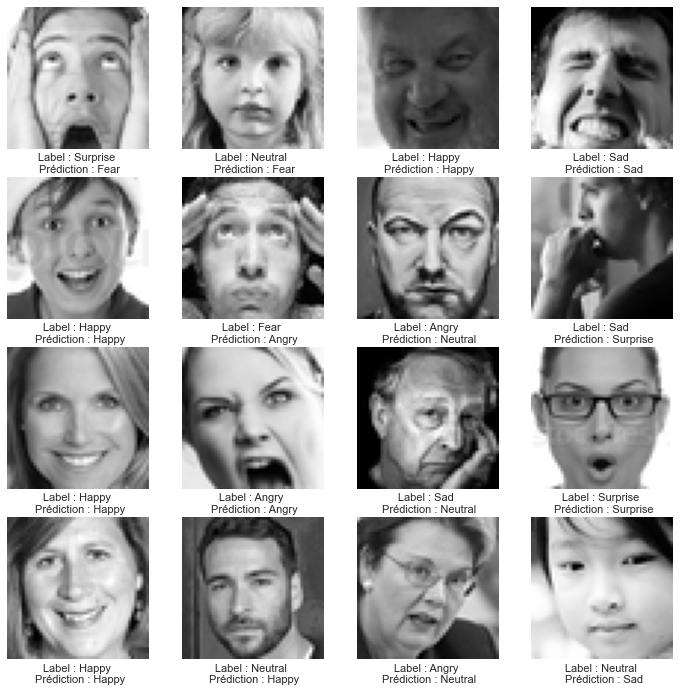

In [47]:
randomExempleTest(Xtest_reshaped[:1000], ytest[:1000], preds)

Sans autant détailler, nous retrouvons les mêmes comportements que décrit précedement. <br/>

Photo 1 : prédiction fear cohérente.<br/>
Photo 2 : erreur grossière. <br/>
Photo 3 : correcte évident. <br/>
Photo 4 : correcte évident. <br/>
Photo 5 : correcte évident. <br/>
Photo 6 : erreur grossière. <br/>
Photo 7 : erreur grossière. <br/>
Photo 8 : la photo n'est pas celle d'un visage et aurait dûe être retiré du dataset <br/>
Photo 9 : correcte évident. <br/>
Photo 10 : correcte évident. <br/>
Photo 11 : prédiction neutral assez cohérente.<br/>
Photo 12 : correcte évident. <br/>
Photo 13 : correcte évident. <br/>
Photo 14 : erreur grossière. <br/>
Photo 15 : prédiction neutral cohérente, peut-être même mieux que angry.<br/>
Photo 16 : prédiction sad assez cohérente.<br/>

Nous voyons encore une fois que sur 15 images valides, nous avons 7 bonnes prédictions, 4 erreurs grossières et 4 prédictions incorrectes mais cohérentes.<br/>

Les résulats sur les images avec une émotion très visible paraissent donc bon. Presque deux fois plus de bonnes prédictions que d'erreurs.


### Partie 7: Cross-Dataset Challenge

Vous devez tester vos modèles (déjà entraînés et testés sur FER) sur un autre ensemble de données pour eváluer la capacité de géneralisation. 
    
L’ensemble de données à tester est le Jaffe dataset qui contient 213 images de 7 expressions faciales pose par 10 modèles féminines japonaises. Chaque image a été étiquetée dans 6 adjectives d’émotion par 60 sujets japonaises. 

L’ensemble de données originel contient des images 256x256 en niveau de gris, dans le format .tiff, sans compression.

Vous avez les données redimensionnées à 48x48 pixels ('jaffe_48x48.csv'), aussi que les données dans la dimension originelle ('jaffe_256x256.csv'). 

* Angry (30 exemples):   Y_test[0:30]   = 0 
* Disgust (29 exemples): Y_test[30:59]  = 1
* Fear (32 exemples): Y_test[59:91]  = 2 
* Happy (31 exemples): Y_test[91:122] = 3 
* Neutral (30 exemples): Y_test[122:152]= 6 
* Surprise (31 exemples): Y_test[152:183]= 5 
* Sad (30 exemples): Y_test[183:213]= 4 

 


### (7a) Charger le fichier de données de test


In [32]:
import numpy as np

# Read from file
X_test_jaffe = np.loadtxt('jaffe_48x48.csv', delimiter=',', dtype=int)
#X_test_jaffe = np.loadtxt('jaffe_256x256.csv', delimiter=',', dtype=int)
y_test_jaffe = np.loadtxt('jaffe_labels.csv', delimiter=',', dtype=int)

# reshape to be [samples][pixels][width][height]
X_test_jaffe  = X_test_jaffe.reshape(X_test_jaffe.shape[0], 1, 48, 48).astype('uint8')
#X_test_jaffe  = X_test_jaffe.reshape(X_test_jaffe.shape[0], 1, 256, 256).astype('uint8')

X_test_jaffe.dtype

dtype('uint8')

<font color=magenta> 
### (7b) Visualisation des visages de Jaffe
</font>

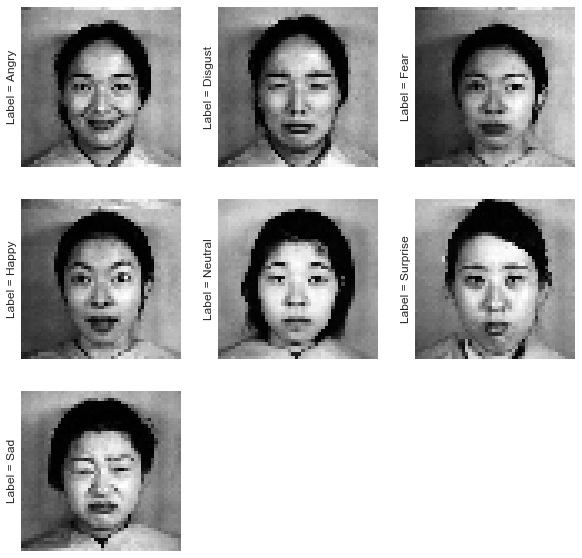

In [33]:
import matplotlib.pyplot as plt
def getLabel(id):
    return ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'][id]
plt.figure(figsize=(10, 10))
j = 0
for i in [5, 40, 70, 105, 135, 171, 191]:
    plt.subplot(330 + 1 + j)
    plt.imshow(np.squeeze(X_test_jaffe[i], axis=0),cmap=plt.get_cmap('gray'))
    plt.gca().get_xaxis().set_ticks([])
    plt.gca().get_yaxis().set_ticks([])
    plt.ylabel('Label = %s' % getLabel(y_test_jaffe[i]), fontsize = 12)
    j = j + 1
plt.show()

<font color=magenta> 
##### À faire:
1. Tester vos modèles sur les 213 images de Jaffe dataset.
2. Faire une analyse des résultats et présenter vos conclusions sur la capacité de generalisation de vos modèles.
</font>

## Partie Final: Conclusion

##### À faire:
1. Résumer et comparer les principaux résultats .
2. Faire une analyse des résultats obtenus et présenter vos conclusions sur les différents modèles que vous avez entraînés.

Notre baseline avait un taux de précision de 22%. Pour cela nous avons utilisé un modèle très simple n'utilisant pas particulièrement de primitives. 

Nous avons ensuite obtenus divers primitives à l'aide des filtres de HOG, LBP et gabor. Le filtre de HOG a retenu notre attention car il présentait de bons résultats. Les filtres de gabor ont aussi présentés des résultats intéressants, ils peuvent donc être utilisés aussi cependant, au vu de leur nombre, ils induisent des primitives de plus grande taille et donc des modèles plus complexes et long à entraîner/prédire. Le modèle LBP semblait peu intéressant.

Nous avons essayés par la suite 2 modèles de classification Knn et Random Forest. Le modèle Knn est très long à prédire au vu de la taille des données d'entrées, mais est assez performant. Le modèle random forest est bien plus rapide pour entrainer et prédire, cependant il est moins performant. Le dévellopement de ce dernier modèle nous a aussi montré qu'il pouvait être intéressant d'équilibrer les classes dans nos datasets. Il aurait été intéressant de poursuivre une étude plus approfondie avec le filtre de gabor sur un random forest, cependant l'équilibre des classes impliquait une trop forte réduction de notre dataset (la classe disgust est largement en sous-effectif).


Finalement nous avons dévellopés un premier modèle Knn utilisant les primitives issus du filtre HOG. Ce modèle présente une meilleure performance : 42% de bonnes classifications.

Suite à notre recherche d'hyperparamètres, nous avons réussis à améliorer le précédent modèle à 48.3% de classifications correctes. Au vu du problème et de la simplicité de nos modèles, le résultat semble être intéressant : on arrive à prédire la moitié du temps l'attitude exprimée dans une photo. De plus, avec les test effectué en partie 6, où nous vérifions non seulement si la prédiction était correcte mais aussi si elle était cohérente, nous avons remarqué que dans les 51,7% d'erreur, un peu plus de la moitié restait généralement très cohérente avec l'image et prédisait un label qu'un humain aurait pu également attribué.

Nous sommes donc satisfait de ce modèle au vu de sa simplicité.